# Sales forecasting Store Sales

### Test challenge
##### Goal: Explore data and predict 6 month of sales for . 

This notebook mainly focuses on the Time Series Analysis, a homework for lesson of DL data science training. We then disscuss advantages and drawbacks of modeling with Seasonal ARIMA and Prophet.

As it usually goes, we start with the Exploratory Data Analysis of the main metrics revealing present trends and patterns in the data, giving a solid foundation for the further causal analysis. 

Also, alternatively to forecasting with Prophet, we use one of the most robust and sophisticated algorythm Extreme Gradient Boosting for regression.

finnaly we try LSTM by Keras for forecasting result, and try to find out advance and drawback. 

!["shop"](rossmann_banner2.png "shop")

---

In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
# %matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import date
# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

In [2]:
# importing train data to learn
train = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
                    parse_dates = True, low_memory = False, index_col = 'YearMonth')

print(train.shape)
# additional store data
# store = pd.read_csv("~/Documents/rossmann_TSA_forecasts/store.csv", 
#                     low_memory = False)
# time series as indexes
train.index

(1580, 11)


DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', name='YearMonth', length=1580, freq=None)

## Exploratory Data Analysis 

In this first section we go through the train data of result data, handle missing values and create new features for further analysis.

In [3]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(12).append(train.tail(12))

In total:  (1580, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2014-01-01,East,2111256114,33,pack2,4340.67530,14091.45400,2014,1,1,2,1
2014-02-01,East,2111256114,33,pack2,4580.52730,19698.48400,2014,2,1,6,1
2014-03-01,East,2111256114,33,pack2,2007.39200,2771.15140,2014,3,1,1,1
2014-04-01,East,2111256114,33,pack2,1651.48010,3096.13310,2014,4,2,3,1
2014-05-01,East,2111256114,33,pack2,6113.11910,26282.81100,2014,5,2,4,1
2014-06-01,East,2111256114,33,pack2,896.07300,2914.21020,2014,6,2,2,1
2014-07-01,East,2111256114,33,pack2,2039.29000,2437.58060,2014,7,3,0,0
2014-08-01,East,2111256114,33,pack2,3485.64890,1089.57250,2014,8,3,0,0
2014-09-01,East,2111256114,33,pack2,3934.42410,3672.25340,2014,9,3,3,1


Short description:
- SalesQty: the turnover for any given day (target variable).
- YearMonth: the Date of shipment and sales.
- Region: the area of store location
- ItemCode: an indicator product code each sales item.
- BrandCode: indicates brand name which numbered.
- Package: indicates type of packages for sales item. 
- ShiQty: indicates quantities of shipment
- SalesQty: indicates quantities of sales
- Year: indicates year of sales
- Quarter: indicates quarter of year
- HolidayDay: indicates number of day during month

## Analysis of Sales

/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


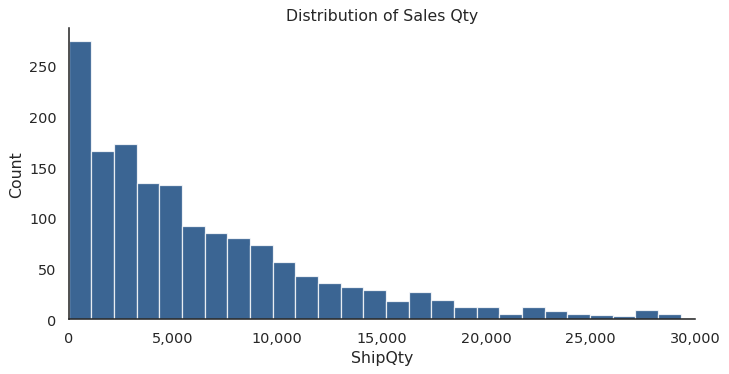

In [4]:
# set graphical parameters
# % matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 90
sns.set_context('notebook', font_scale=1.05)
sns.set_style('white')

pal = ['#066b2b', '#0a3e78', '#ae1626','#444745','#55a15a', '#5588a1', 'indianred']

fig, ax = plt.subplots(figsize = (8, 4))

ax.hist(train['ShipQty'], alpha = .8, bins=60, color = pal[1])
ax.set_title('Distribution of Sales Qty')
ax.set_ylabel('Count', fontname = 'Arial')
ax.set_xlabel('ShipQty', fontname = 'Arial')
ax.set_xlim(0, 30000)

x_vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0f}'.format(x) for x in x_vals], fontname = 'Arial')

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])

sns.despine();

* check on the sales of zero on holiday for each brand, is there any finding

In [5]:

# fig,axes=plt.subplots(1,1)
# arr_train = train['SalesQty'].to_string(index=False)

# print(type(train))
# int_train = np.asscalar(arr_train)
# arr_train=train.as_matrix()

# sns.boxplot(data= arr_train,orient="h",palette="Set3",ax=axes[1])  #水平显示 


In [6]:
train[train['ShipQty']==0].groupby(['HolidayDay','BrandCode'])['SalesQty'].aggregate('count').unstack()


BrandCode,33,34,53,74
HolidayDay,,,,
0,15.0,9.0,5.0,3.0
1,5.0,1.0,4.0,NaN
2,6.0,2.0,1.0,NaN
3,6.0,2.0,NaN,NaN
4,2.0,NaN,2.0,NaN
5,2.0,1.0,1.0,NaN
7,10.0,2.0,2.0,NaN
8,2.0,2.0,1.0,NaN


`BrandCode` could be one of fact on prediction parameter, 

### ECDF: empirical cumulative distribution function

To get the first impression about continious variables in the data we can plot ECDF. from here we can see the shipment and sales keeping a very good balance. 

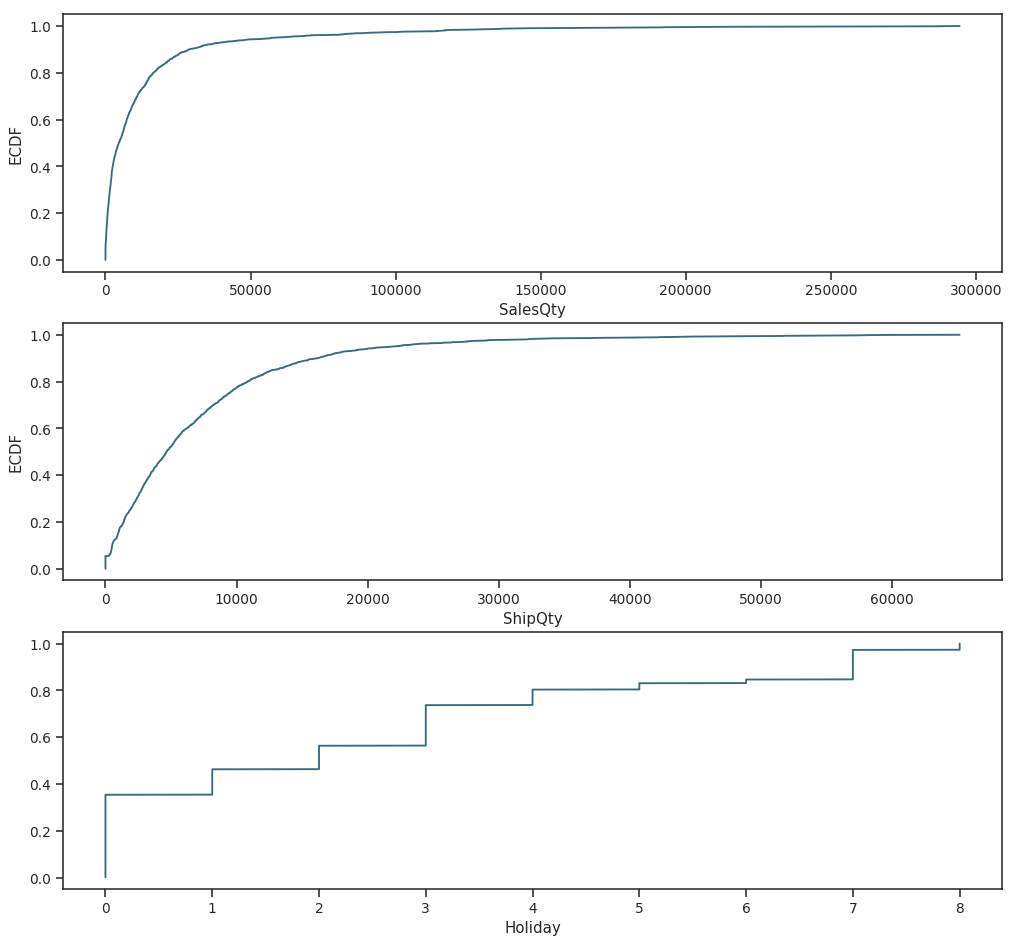

In [7]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 12))

plt.subplot(311)
cdf = ECDF(train['SalesQty'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('SalesQty'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['ShipQty'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('ShipQty');plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['HolidayDay'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Holiday');

About 20% of data has zero amount of sales,  30% of holiday are 3 days, shipment is less than sales qty. 

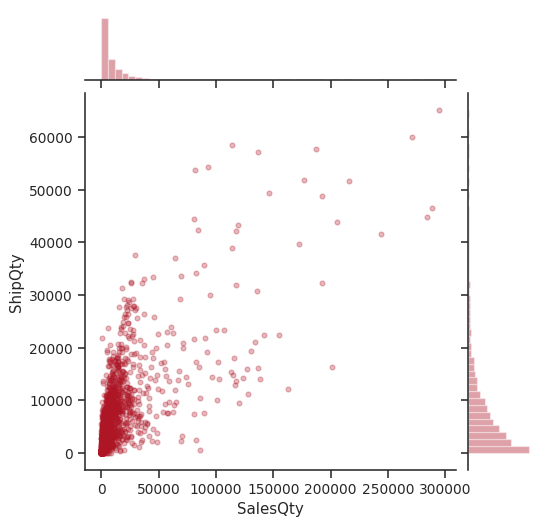

In [8]:
g= sns.jointplot(train['SalesQty'],train['ShipQty'], color=pal[2], alpha= 0.3, joint_kws={'s':15})


## Impact of Holiday on Shipment

Text(0.5, 1.0, 'Shipment of Holiday Month')

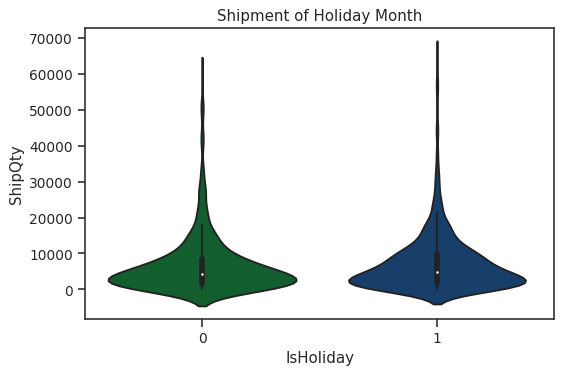

In [9]:
fig, ax = plt.subplots()
ax = sns.violinplot(x= 'IsHoliday', y = 'ShipQty', data=train, palette=pal)
ax.set_title('Shipment of Holiday Month')


- if only take look on the distrubution of shipment, there is no big difference of shipment quatities. 

/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


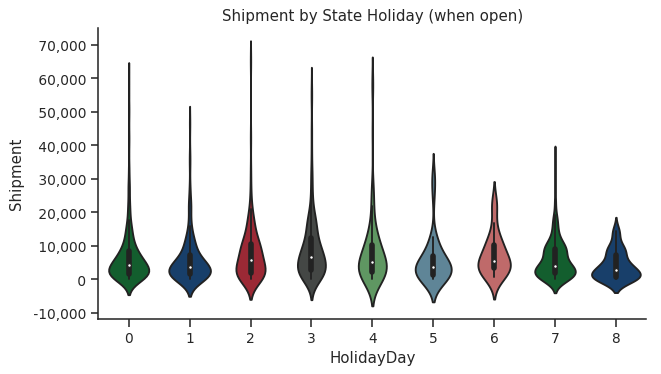

In [10]:
fig, ax = plt.subplots(figsize = (7, 4))
ax = sns.violinplot(x = 'HolidayDay', y = 'ShipQty', data = train, palette = pal)
ax.set_title('Shipment by State Holiday (when open)', fontname = 'Arial')
ax.set_ylabel('Shipment', fontname = 'Arial')


x_vals = ax.get_xticks()
ax.set_xticks(x_vals)

y_vals = ax.get_yticks()
ax.set_yticklabels([' {:,.0f}'.format(y) for y in y_vals], fontname = 'Arial')

sns.despine();

- seems there is no difference of shipment amount distribution

### Missing values or some accidents 
#### on working day of zero sales stores

In [11]:
# Sales is zero during working day
zero_workingDaySales=train[(train.ShipQty == 0) & (train.HolidayDay==0) ]
print("in total:" ,zero_workingDaySales.shape)
zero_workingDaySales.head(10)


in total: (32, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2016-07-01,East,2992101565,34,pack3,0.0,73.398705,2016,7,3,0,0
2017-09-01,East,2992101565,34,pack3,0.0,1397.969500,2017,9,3,0,0
2016-07-01,East,5203395462,33,pack2,0.0,0.000000,2016,7,3,0,0
2016-08-01,East,5203395462,33,pack2,0.0,0.000000,2016,8,3,0,0
2017-07-01,Inner,3331397693,74,pack3,0.0,487.128970,2017,7,3,0,0
2017-08-01,Inner,3331397693,74,pack3,0.0,71.328705,2017,8,3,0,0
2017-09-01,Inner,3331397693,74,pack3,0.0,0.000000,2017,9,3,0,0
2015-11-01,Inner,6288617494,33,pack4,0.0,0.000000,2015,11,4,0,0
2015-12-01,Inner,6288617494,33,pack4,0.0,0.000000,2015,12,4,0,0


,Year,Month,ShipQty
count,32.000000,32.00000,32.0
mean,2015.843750,9.56250,0.0
std,1.019468,2.03101,0.0
min,2014.000000,6.00000,0.0
25%,2015.000000,7.75000,0.0
50%,2016.000000,11.00000,0.0
75%,2017.000000,11.00000,0.0
max,2017.000000,12.00000,0.0


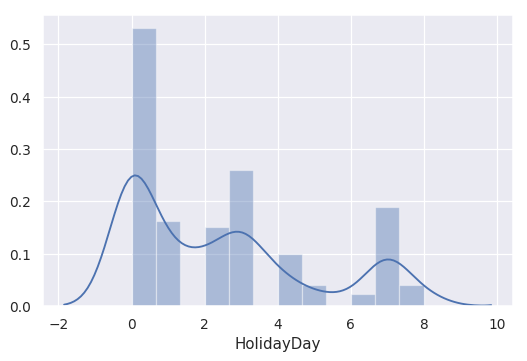

In [12]:
sns.set(style="darkgrid")
sns.distplot(train.HolidayDay)
train[(train.ShipQty==0)&(train.HolidayDay==0)].loc[:,['Year','Month','ShipQty']].describe()

There're 33 stores with zero sales in the data __during working day__. It is about 0.2% of the total amount of observations. there are some facts involved, maybe is the manifestations. To avoid any biased , we want see the distribution of the data.  


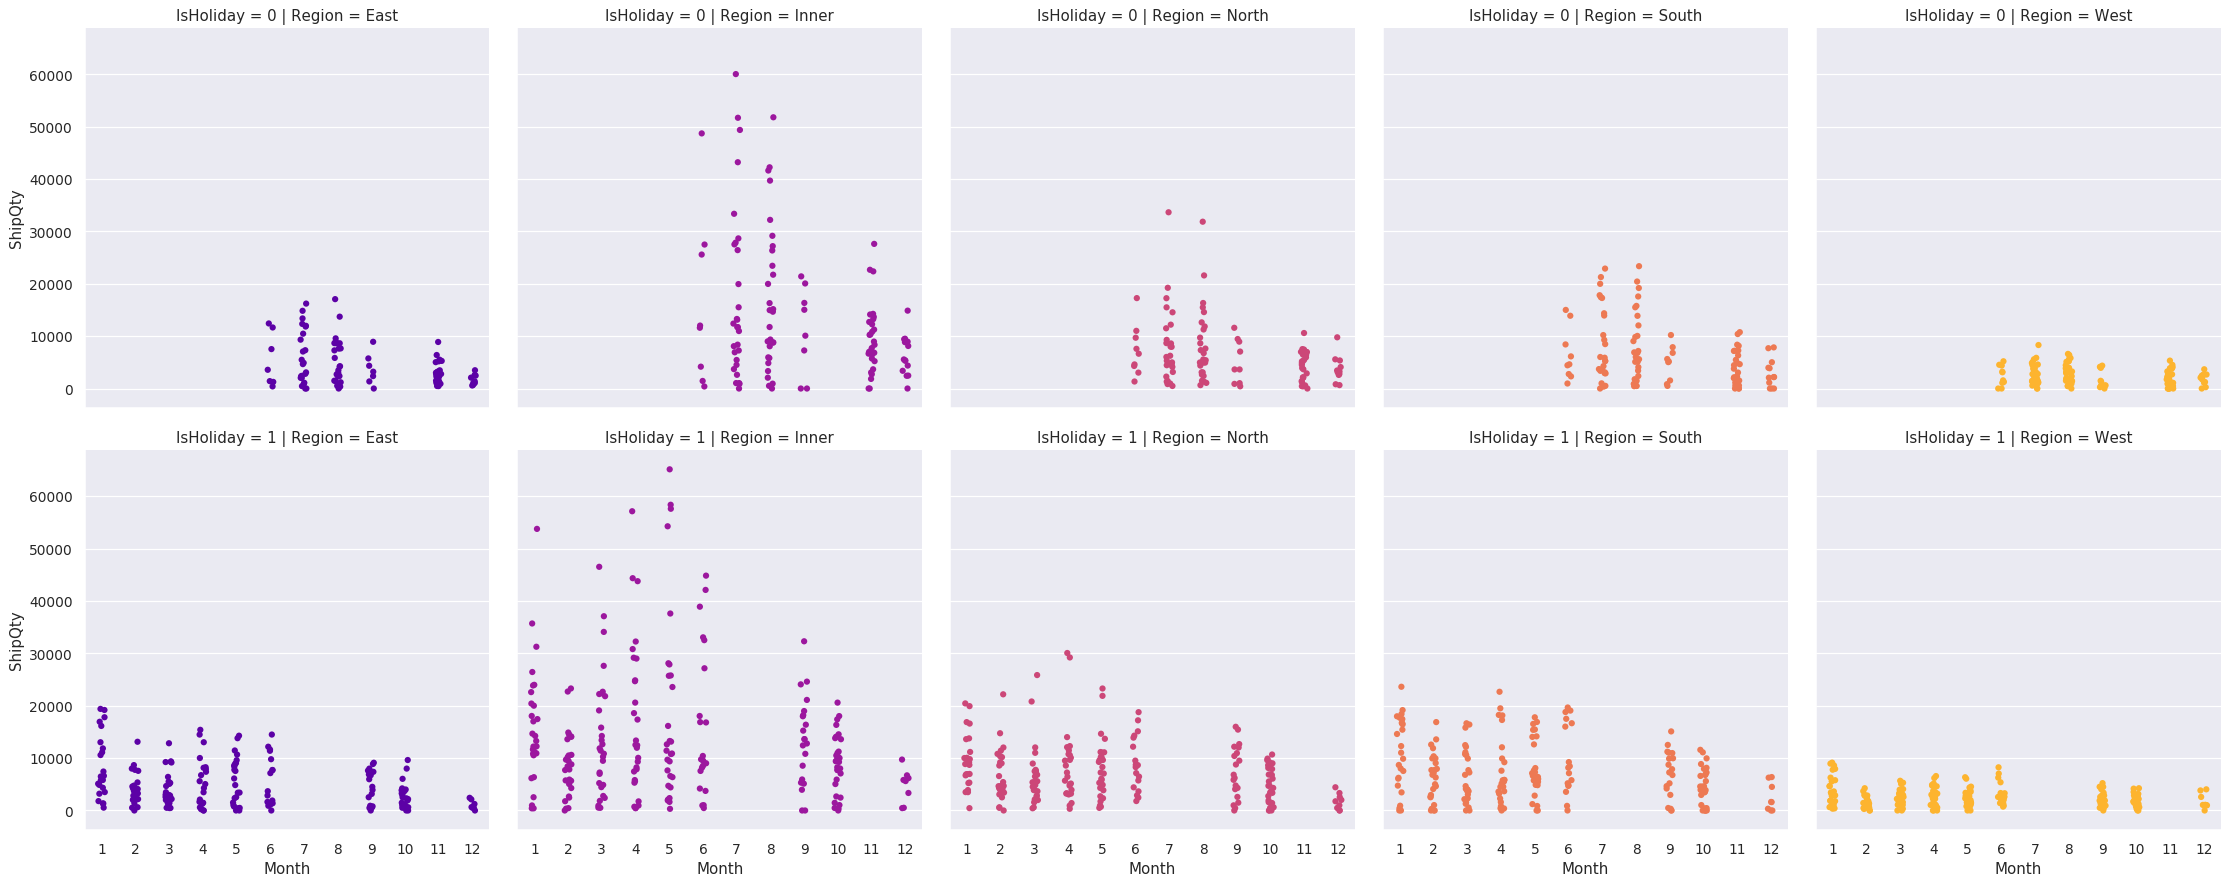

In [13]:
# sales trends
c = '#386B7F'
sns.catplot(data = train, x = 'Month', y = "ShipQty", 
               col = 'Region', # per region type in cols
               palette = 'plasma',
               hue = 'Region',
               row = 'IsHoliday', # per promo in the store in rows
               color = c) 

##### - very interesting finding, before holiday and after holiday, very easy to see the shipment got increace

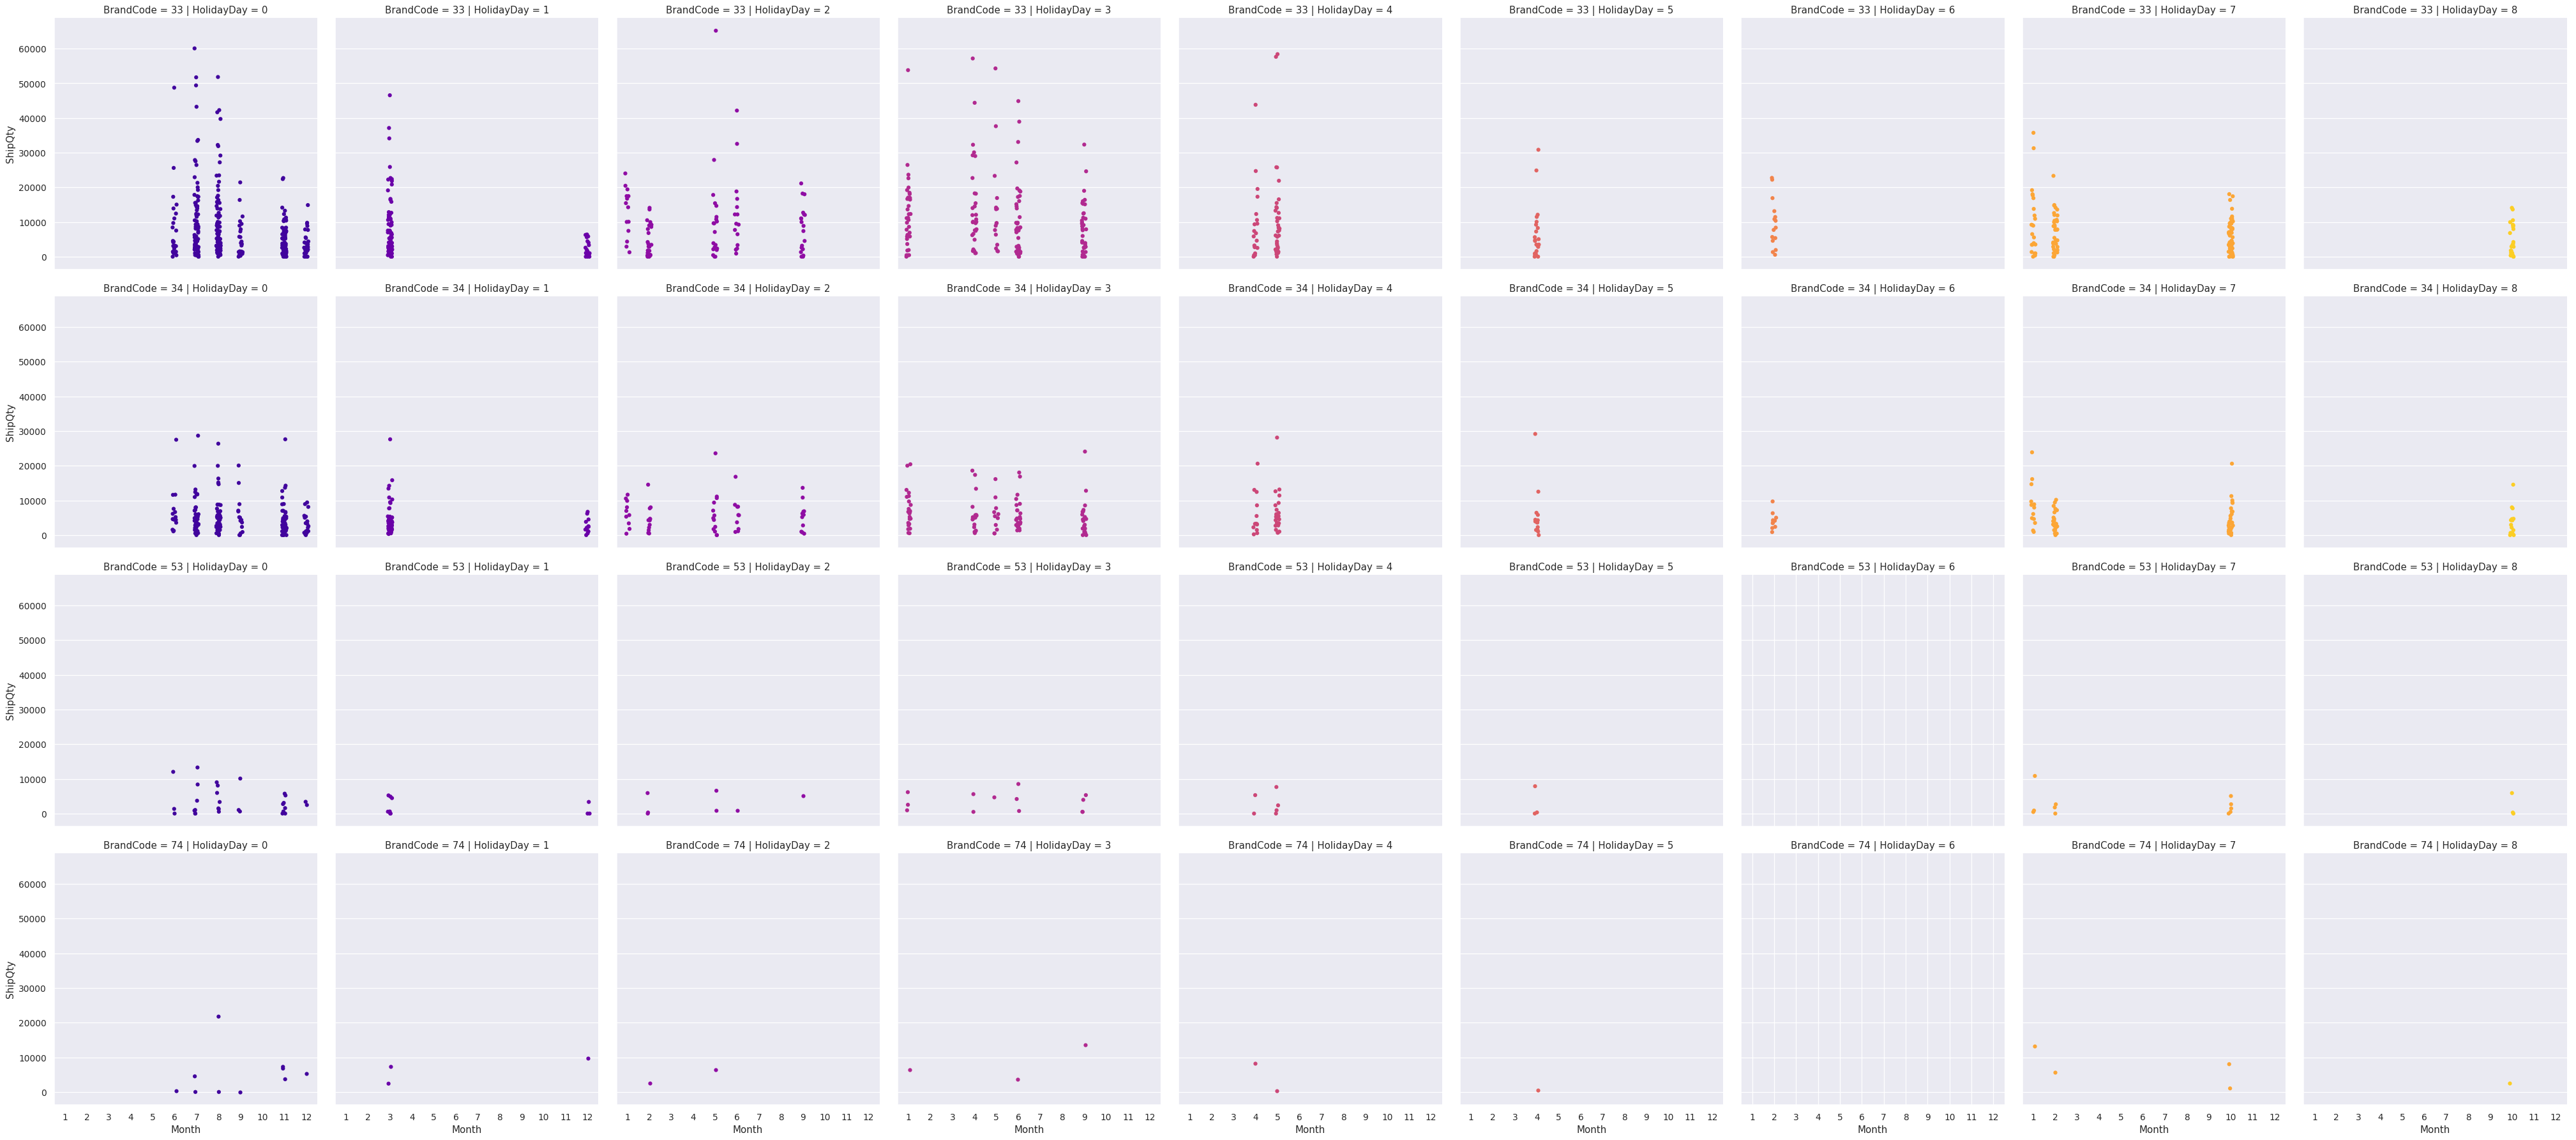

In [14]:
# sale per BrandCode trends
sns.catplot(data = train, x = 'Month', y = "ShipQty", 
               col = 'HolidayDay', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'HolidayDay',
               row = 'BrandCode',
              
               color = c) 

the correlation of SalesQty & Days of Holiday　&　Brand are show that, those three feature are impact sales very much. `BrandCode = 33` is very popular. 

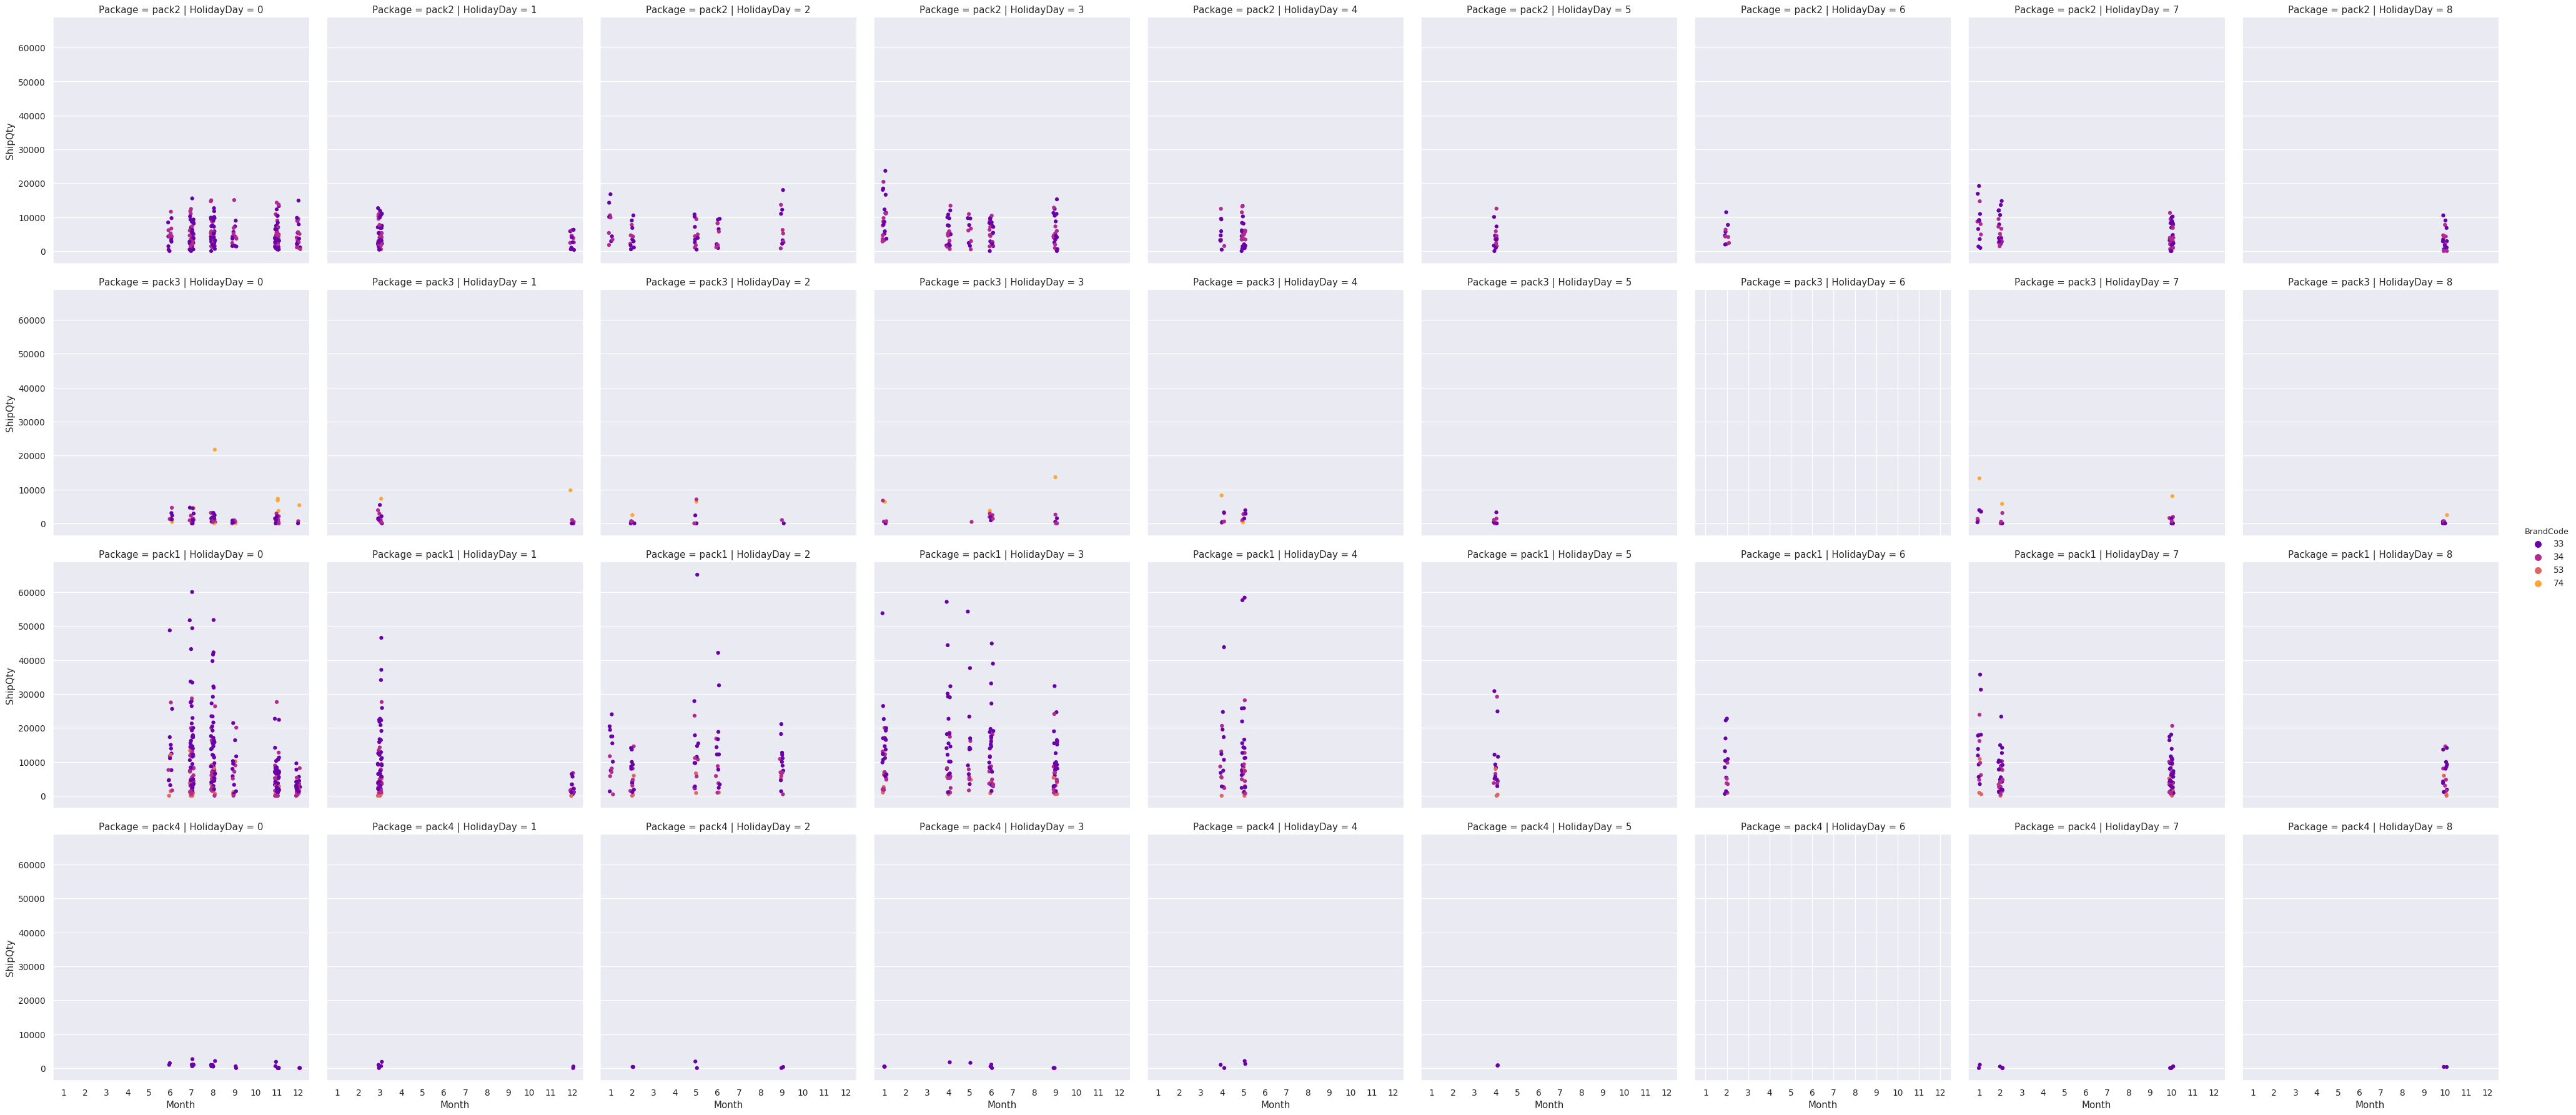

In [15]:
# sale per sales trends
sns.catplot(data = train, x = 'Month', y = "ShipQty", 
               col = 'HolidayDay', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'BrandCode',
               row = 'Package',
              
               color = c) 

We see that package is also correlative to sales. `package 1` is very positive correlative to each brand

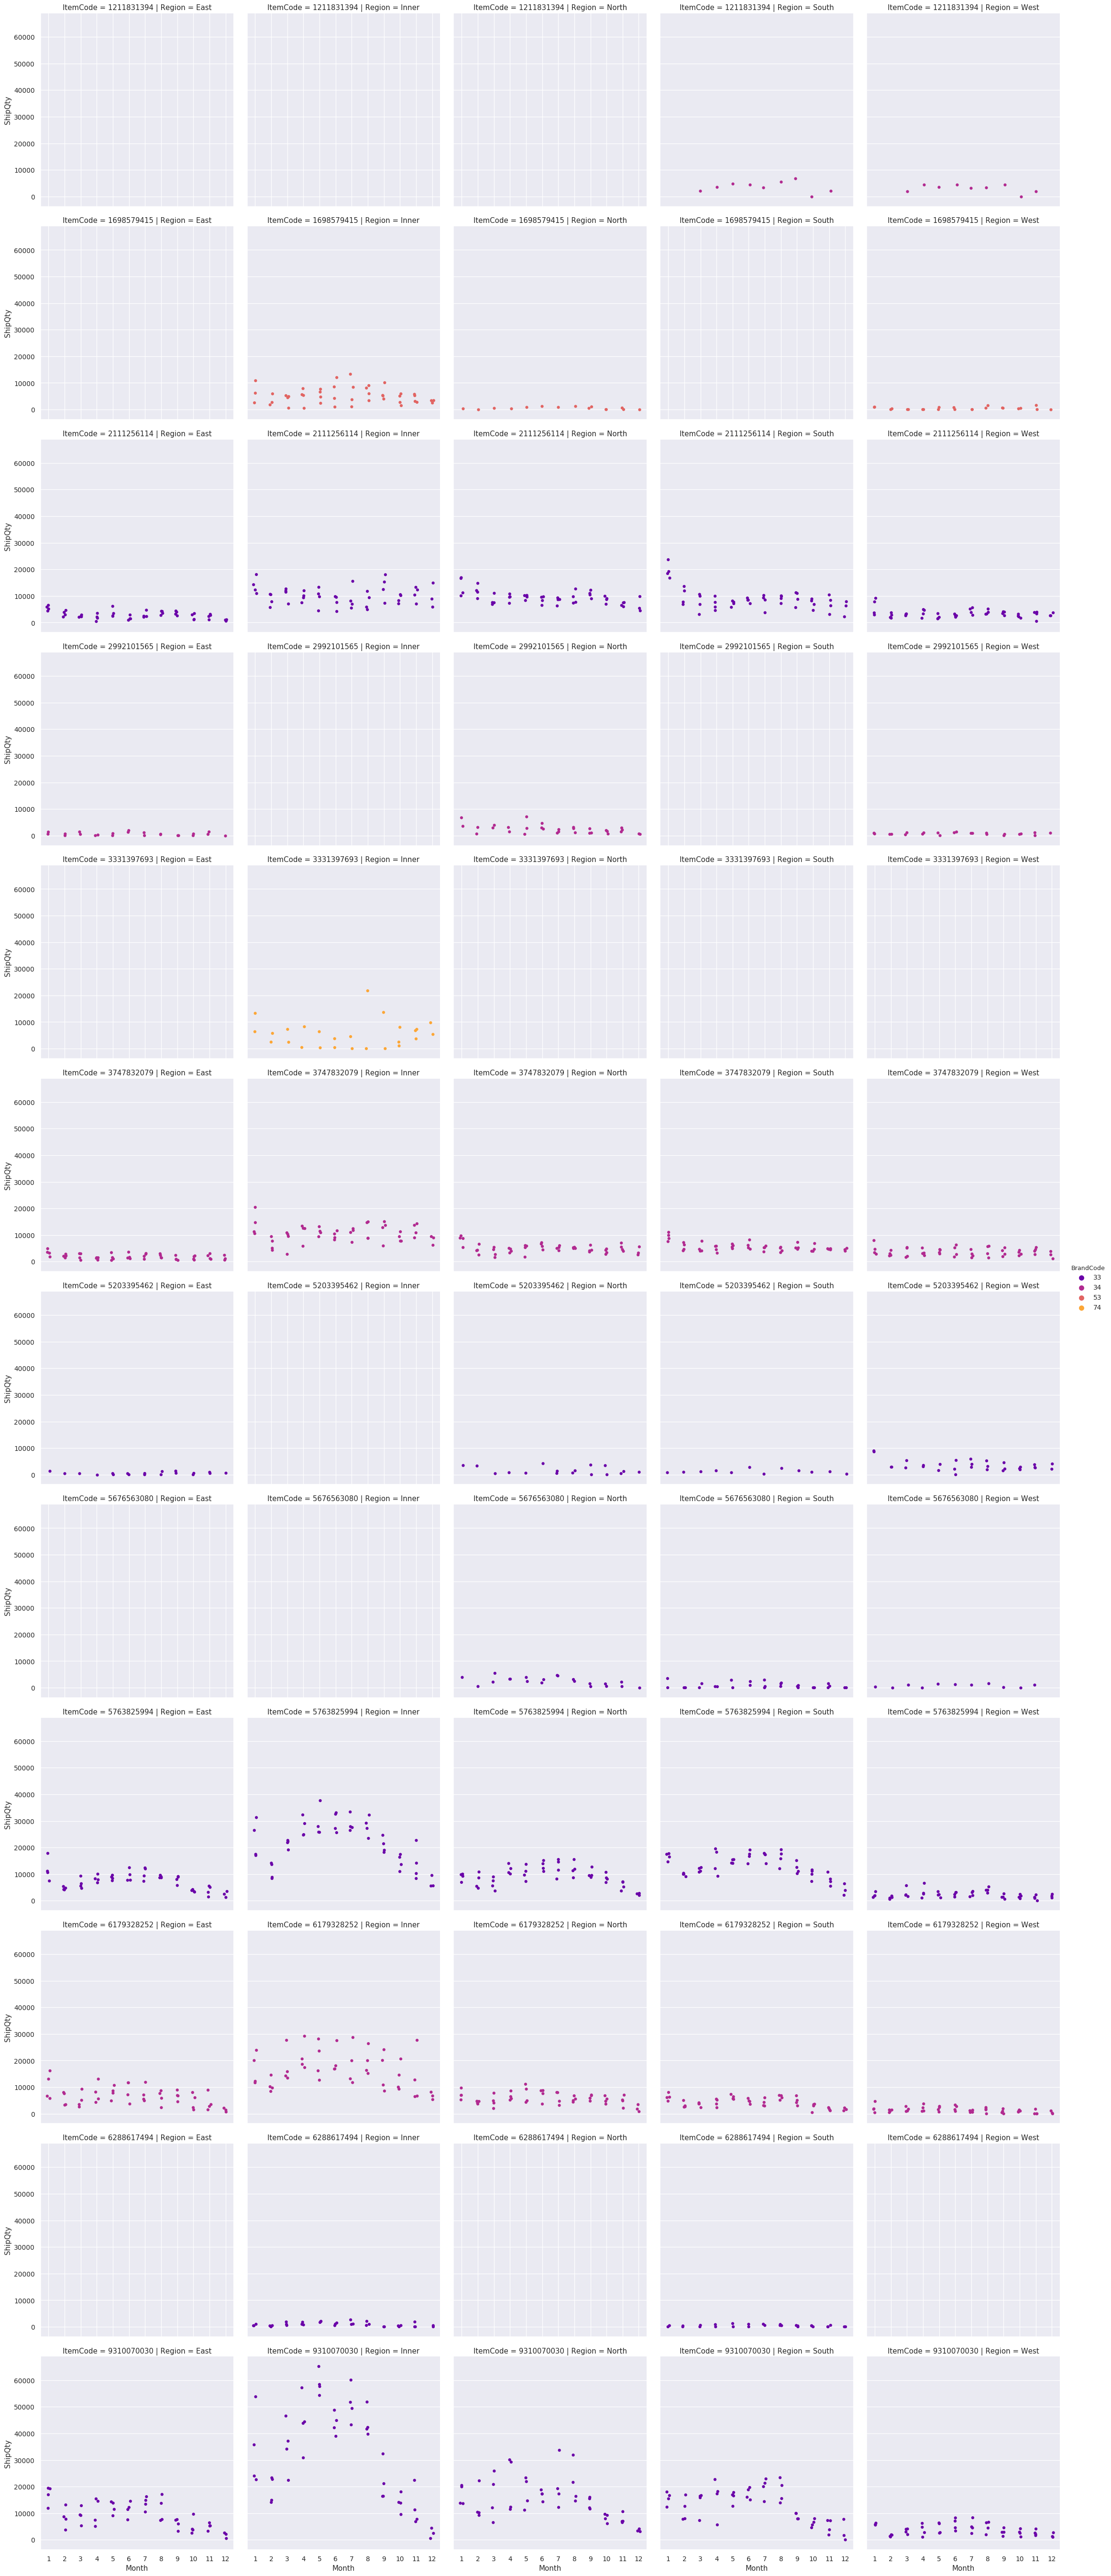

In [16]:
# sale per customer trends
sns.catplot(data = train, x = 'Month', y = "ShipQty", 
               col = 'Region', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'BrandCode',
               row = 'ItemCode',
              
               color = c) 

- interesting finding, the `Item code` is very  big defference of `sales` in each ereas. like eg. in east area, `ItemCode= 1698579415, ItemCode = 1211831394` got no sales. 

### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the `seaborn` heatmap:

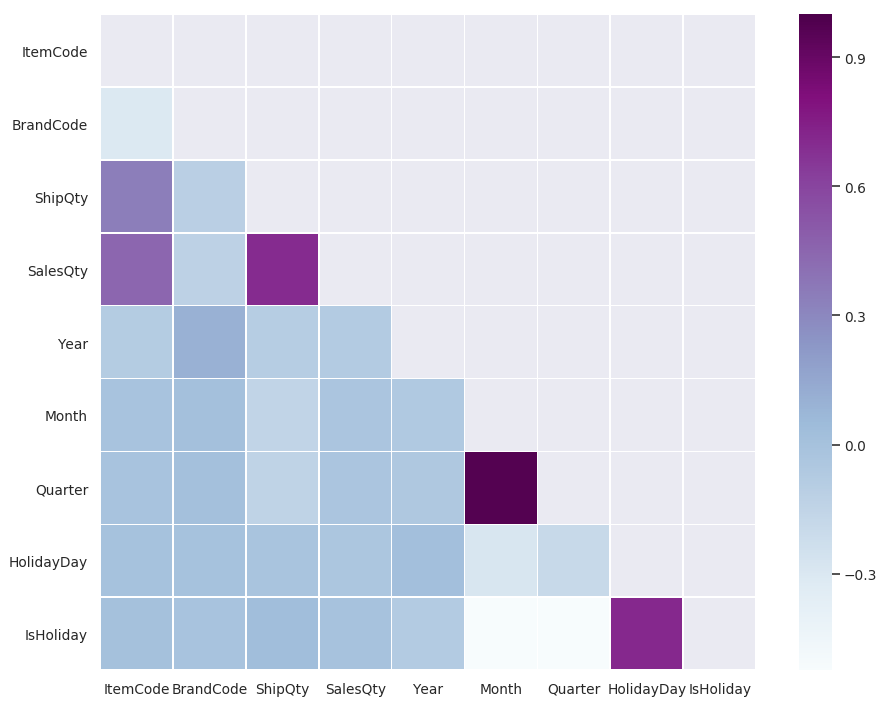

In [17]:
# Compute the correlation matrix 

corr_all = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

As mentioned before, we have a strong positive correlation between the `ItemCode` and  `SalesQty` .  We can also observe a positive correlation between the `shipQty`  and  `ItemCode`. 


There are several things here:
- In case of holiday,  `Shipment` tend to peak(!). Though we should note that `Holiday` on different month is affecting Sales. So it is mainly data from `Holiday` . and if holiday day is `three` days, the sales keep close to peak (!).
- On the contrary, stores that during working day tend to make most of the `Sales` on `east` and `inner` duing month of `6,7,8,9,11,12` .  The same trend follow the stores which have different `package` specially for `package1` and `package2`
- `Itemcode` alone `9310070030` seem to be correlated to any significant change in the `Shipment` amount. This can be also prooved by the blue pale area on the heatmap above which is `ItemCode` is very positive correlation with the `shipQty` and `SalesQty`

---

## Conclusion of EDA

- The most selling and crowded `ItemCode` is `9310070030`.


- The best "Sale per Region"  is `east` and `inner`. We could also assume that the stores of this types are situated in the central city or tie one areas, so that customers buying behavior is not that sensitive of holiday. not only small volumns or big volumns. 


- Low `SalesQty` amount for `Region` indicates to the possible fact that people shop there essentially for small things. Which can also indicate to the label of this store type - "urban" - as it's more accessible for public, and customers don't mind shopping there from time to time during a week.


- Customers tends to buy more on `Month` of `Holiday`, when there is no holiday month at all the sales of that month close to `zero`.





## Time-Series Analysis per Store Type

What makes a time series different from a regular regression problem? 

- It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.


- Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for China Spring festival holidays, which we will see in this dataset.

<div class = "alert alert-block alert-info"> We build a time series analysis on region instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonaltities in the dataset. </div>

### Seasonality

We take five region from regions to represent their group:
- region number 1 for `Region` East
- region number 2 for `Region` Inner, 
- region number 3 for `Region` West 
- region number 4 for `Region` North.
- region number 5 for `Region` South. 


It also makes sense to downsample the data from days to weeks using the `resample` method to see the present trends more clearly.

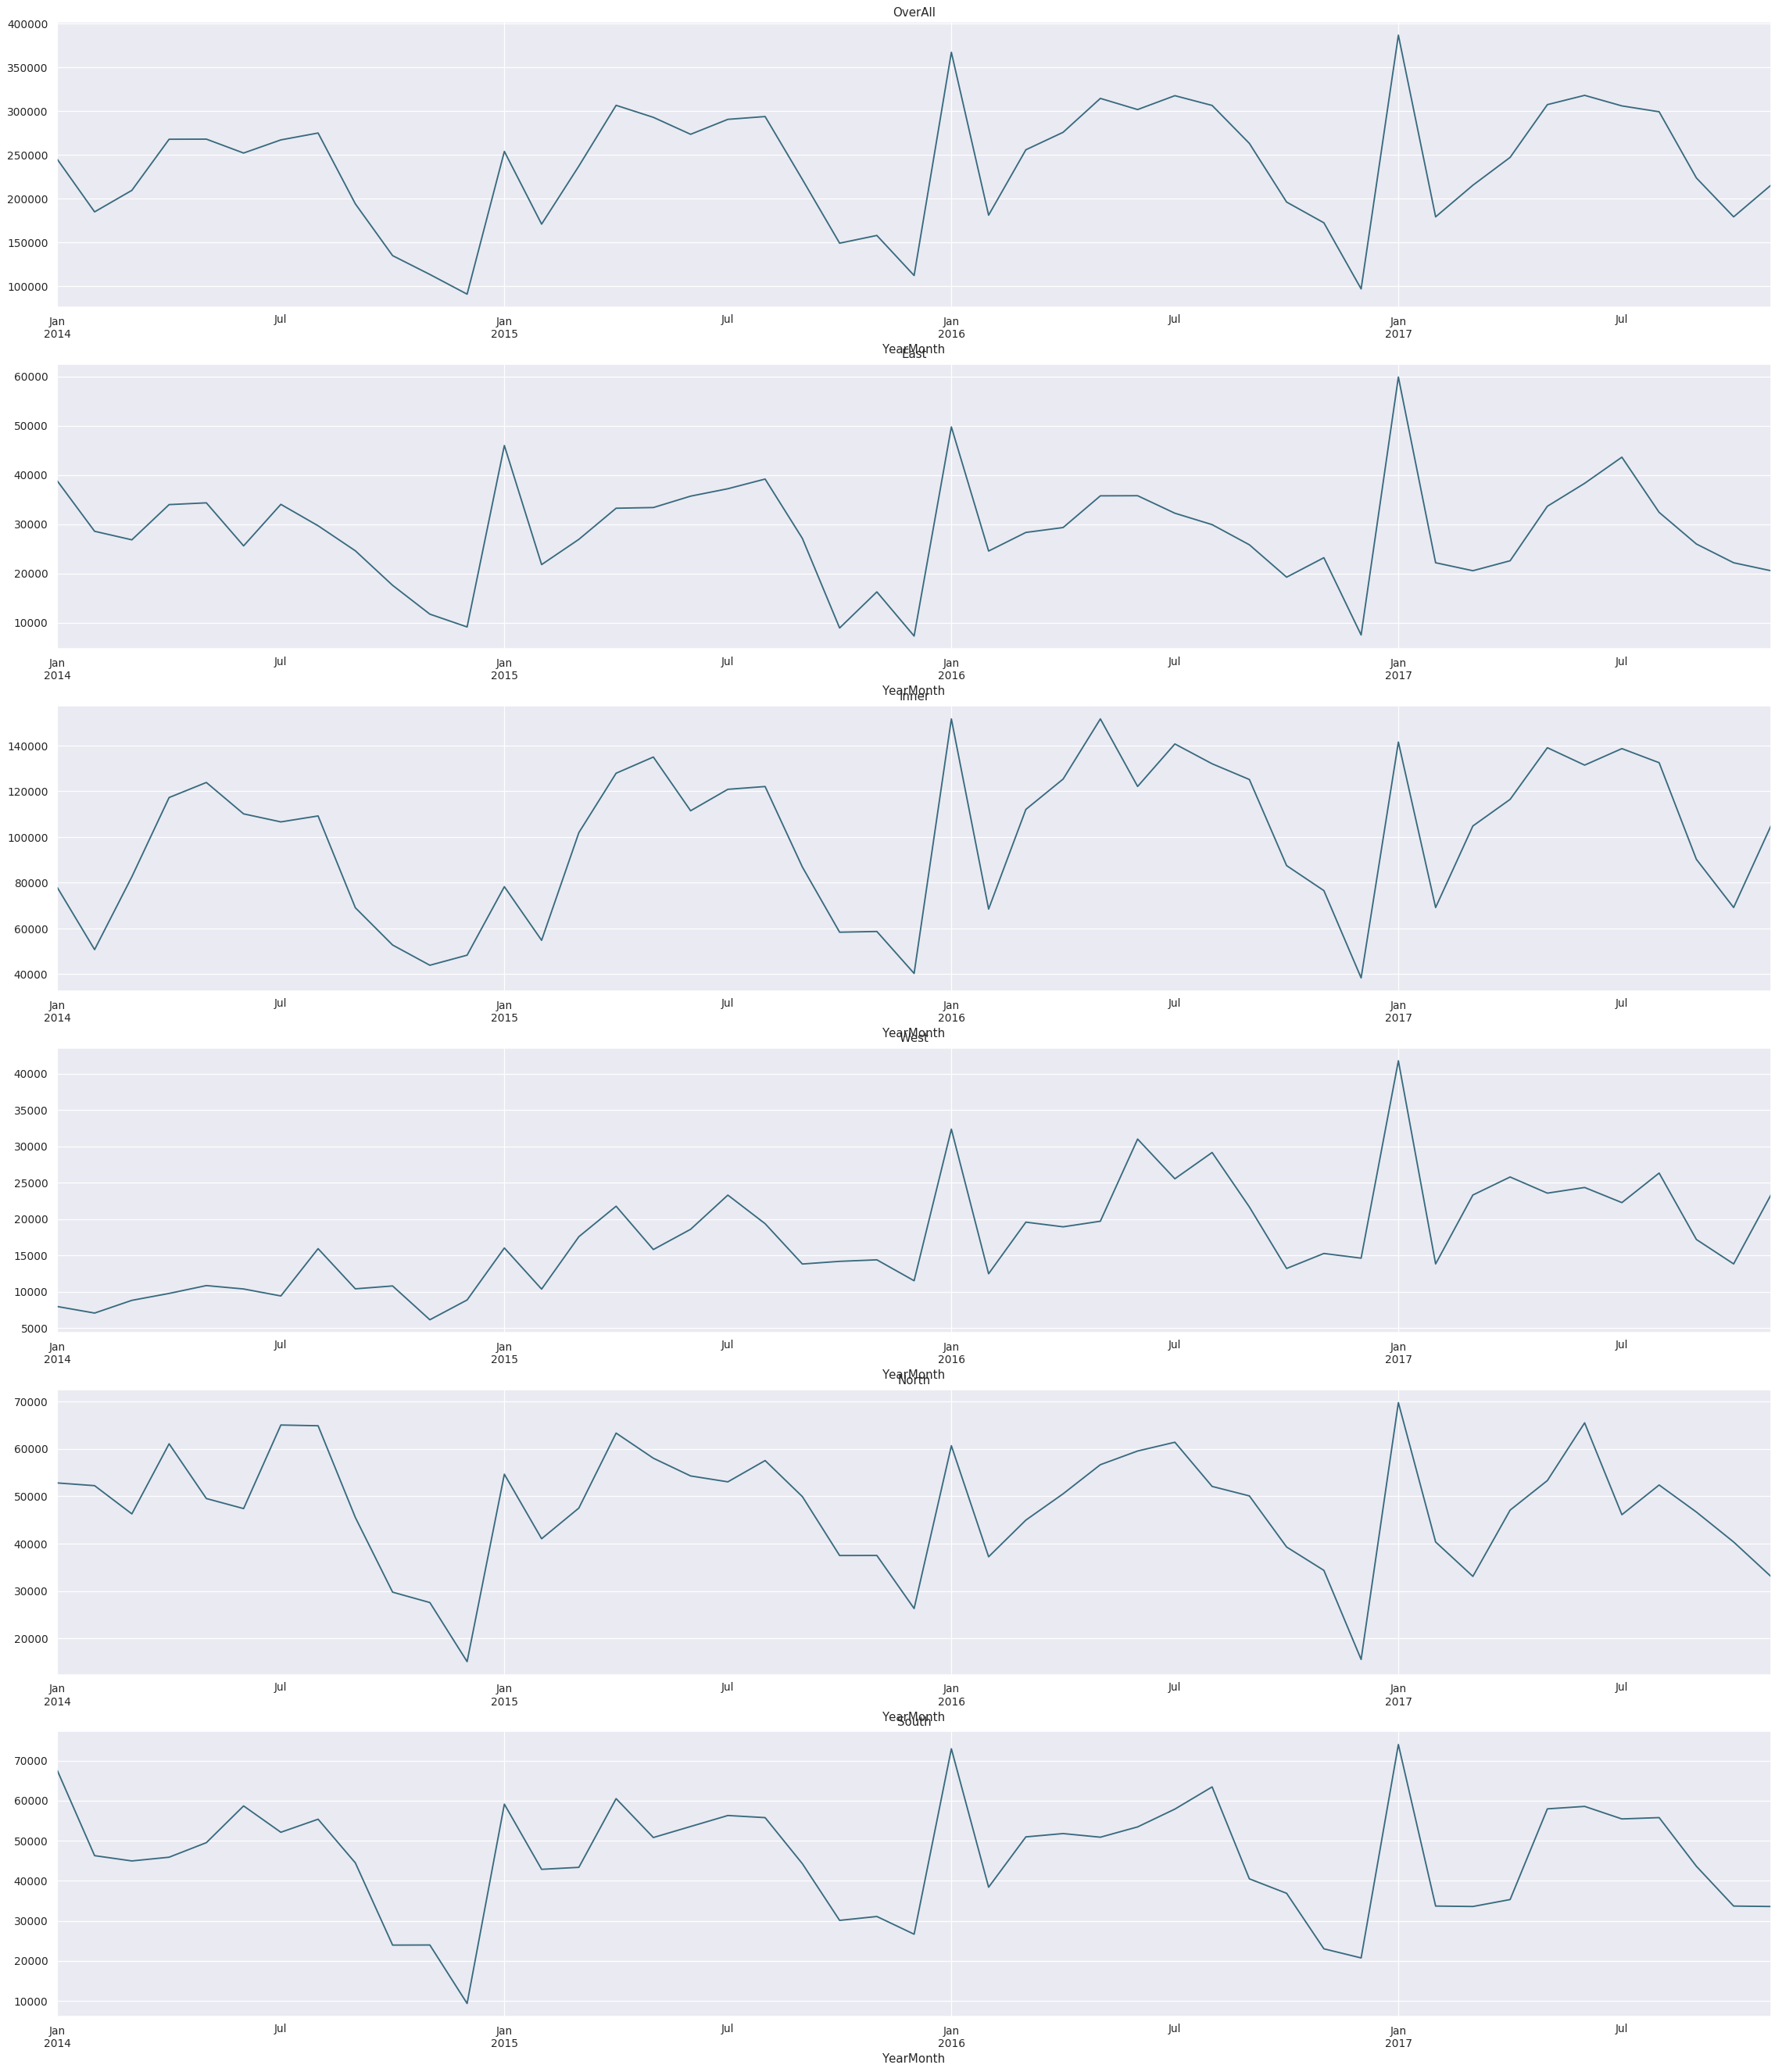

In [18]:
# preparation: input should be float type
train['SalesQty'] = train['SalesQty'] * 1.0

# sales types
sales_0 = train['ShipQty']
sales_1 = train[train.Region == 'East']['ShipQty']
sales_2 = train[train.Region == 'Inner']['ShipQty']
sales_3 = train[train.Region == 'West']['ShipQty']
sales_4 = train[train.Region == 'North']['ShipQty']
sales_5 = train[train.Region == 'South']['ShipQty']

f, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, figsize = (28, 35))

# area types
sales_0.resample('M').sum().plot(color = c, ax = ax0, title='OverAll')
sales_1.resample('M').sum().plot(color = c, ax = ax1, title='East')
sales_2.resample('M').sum().plot(color = c, ax = ax2, title='Inner')
sales_3.resample('M').sum().plot(color = c, ax = ax3, title='West')
sales_4.resample('M').sum().plot(color = c, ax = ax4, title='North')
sales_5.resample('M').sum().plot(color = c, ax = ax5, title='South')

<div class = "alert alert-block alert-success"> the sales of each area can see peek are quite diffent during year. for East aear, peek is coming at first year, for West area, peak is coming at 2016, for Inner peak is coming at 2017, for North area, the peak is keeping very good trend, for south area, the peak is coming at first two at 2015  </div>

### Autocorrelaion

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. 

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. 

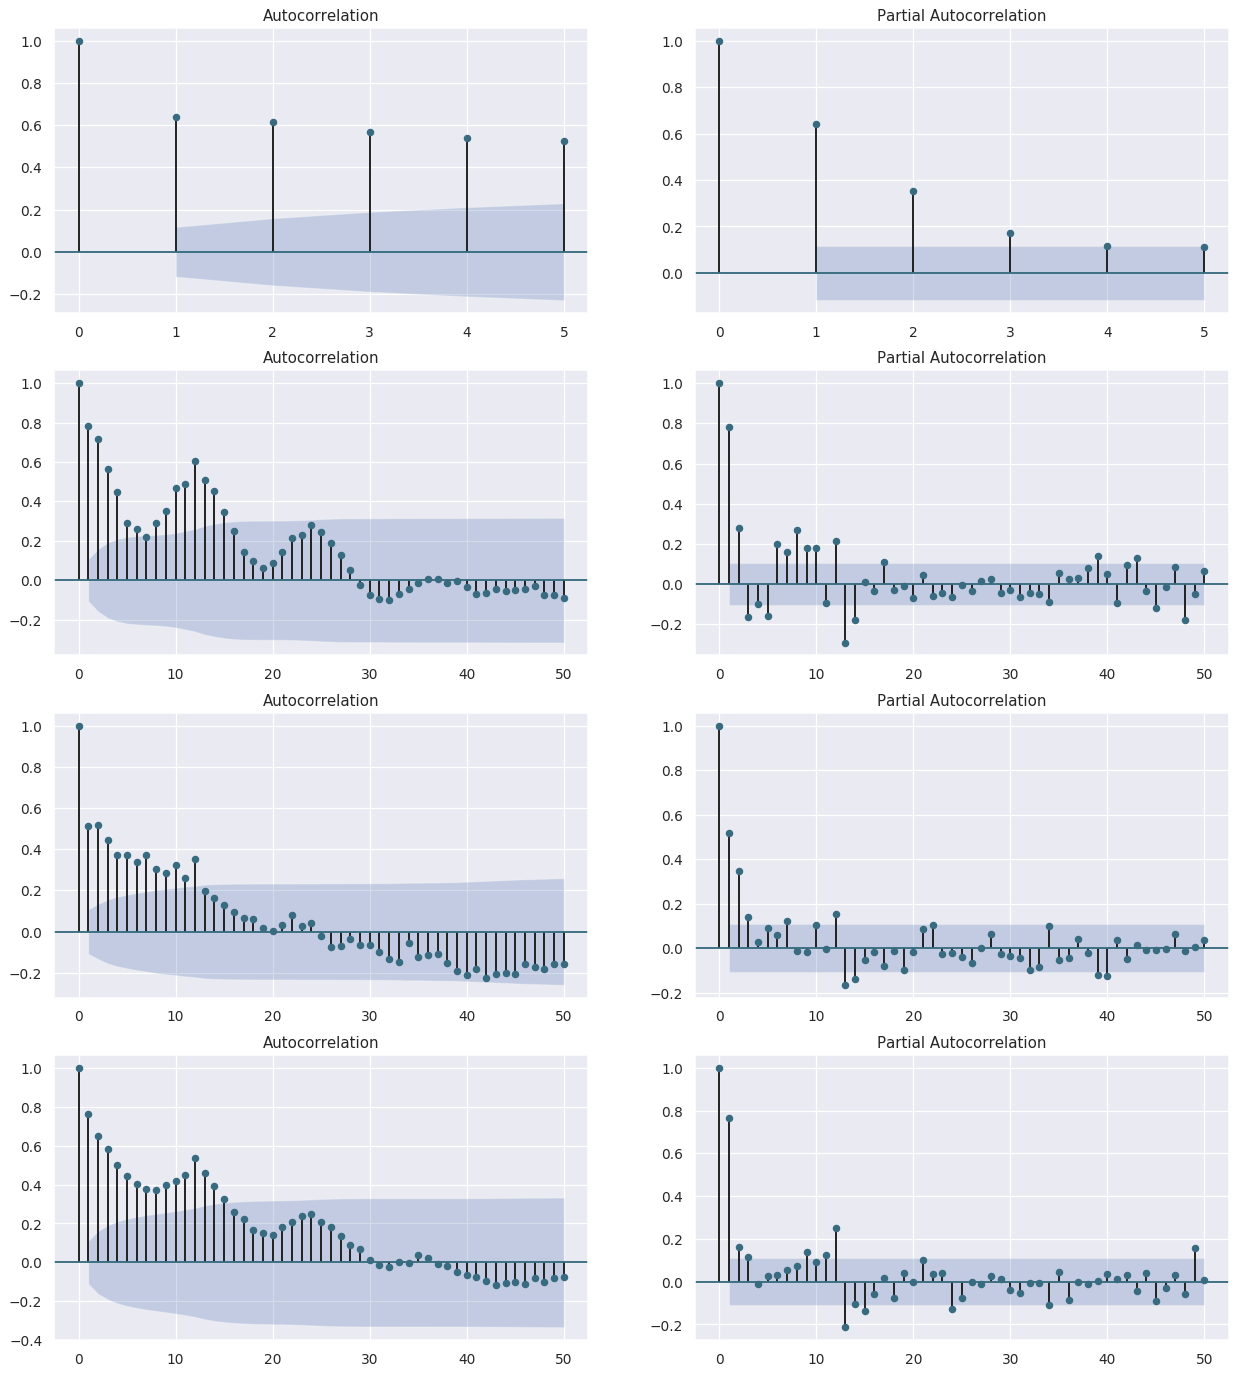

In [19]:
# figure for subplots
plt.figure(figsize = (15, 18))

# acf and pacf for East
plt.subplot(421); plot_acf(sales_1, lags = 5, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_1, lags = 5, ax = plt.gca(), color = c)

# acf and pacf for West
plt.subplot(423); plot_acf(sales_2, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_2, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for Inner
plt.subplot(425); plot_acf(sales_3, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_3, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for North
plt.subplot(427); plot_acf(sales_4, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_4, lags = 50, ax = plt.gca(), color = c)


plt.show()



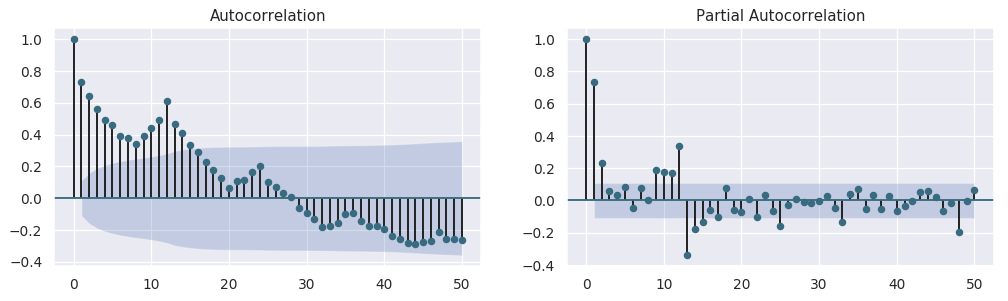

In [20]:
plt.figure(figsize=(12,15))

# acf and pacf for South
plt.subplot(425); plot_acf(sales_5, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_5, lags = 50, ax = plt.gca(), color = c)
plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'Region', from East to South. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

Falters ACF has trailing characteristics, PACF truncated features, the AR model is more reasonable, if PACF trailing characteristics, ACF has truncated characteristics, the MA model is more reasonable,

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).


## Time Series Analysis and Forecasting with Prophet
#### Forecasting for the next month for the first store

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called [Prophet](https://research.fb.com/prophet-forecasting-at-scale/). It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing [automated forecasting which are already implemented in R](https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima) at scale in Python 3.

In [60]:
# importing data
df = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv",  
                    low_memory = False)


# sales for the area East 
shipment_east = df[df.Region == 'East'].loc[:, ['YearMonth', 'ShipQty']]
shipment_west = df[df.Region == 'West'].loc[:, ['YearMonth', 'ShipQty']]
shipment_inner = df[df.Region == 'Inner'].loc[:, ['YearMonth', 'ShipQty']]
shipment_south = df[df.Region == 'South'].loc[:, ['YearMonth', 'ShipQty']]
shipment_north = df[df.Region == 'North'].loc[:, ['YearMonth', 'ShipQty']]

# reverse to the order: from 2014 to 2017
shipment_east = shipment_east.sort_index(ascending = False)
shipment_west = shipment_west.sort_index(ascending = False)
shipment_inner = shipment_inner.sort_index(ascending = False)
shipment_south = shipment_south.sort_index(ascending = False)
shipment_north = shipment_north.sort_index(ascending = False)

# to datetime64
shipment_east['YearMonth'] = pd.DatetimeIndex(shipment_east['YearMonth'])
shipment_west['YearMonth'] = pd.DatetimeIndex(shipment_west['YearMonth'])
shipment_inner['YearMonth'] = pd.DatetimeIndex(shipment_inner['YearMonth'])
shipment_north['YearMonth'] = pd.DatetimeIndex(shipment_north['YearMonth'])
shipment_south['YearMonth'] = pd.DatetimeIndex(shipment_south['YearMonth'])


shipment_east.dtypes
shipment_west.dtypes
shipment_inner.dtypes
shipment_north.dtypes
shipment_south.dtypes

YearMonth    datetime64[ns]
ShipQty             float64
dtype: object

In [65]:
# from the prophet documentation every variables should have specific names
shipment_east = shipment_east.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment_west = shipment_west.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment_inner = shipment_inner.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment_north = shipment_north.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment_south = shipment_south.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
print(shipment_east.head())
print(shipment_west.head())
print(shipment_inner.head())
print(shipment_north.head())
print(shipment_south.head())

            ds           y
276 2017-11-01   5275.6357
275 2017-10-01   3699.5354
274 2017-09-01   3212.0049
273 2017-08-01   7661.6187
272 2017-07-01  10473.8520
             ds          y
1579 2017-11-01  4083.9331
1578 2017-10-01  1092.4105
1577 2017-09-01  1306.3787
1576 2017-08-01  1916.3315
1575 2017-07-01  4479.1660
            ds          y
617 2017-11-01  22377.213
616 2017-10-01  14079.689
615 2017-09-01  16352.037
614 2017-08-01  51812.746
613 2017-07-01  49395.105
            ds           y
936 2017-11-01   6494.4927
935 2017-10-01   9207.4160
934 2017-09-01  11601.0810
933 2017-08-01  14597.3960
932 2017-07-01  12196.0390
             ds           y
1249 2017-11-01   7263.7041
1248 2017-10-01   7957.4639
1247 2017-09-01   7895.6006
1246 2017-08-01  13887.0730
1245 2017-07-01  14374.4050


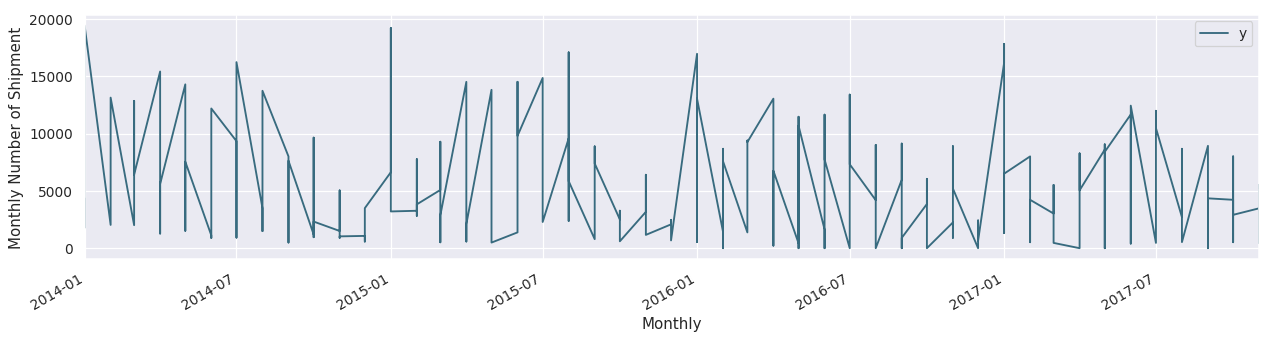

In [66]:
# plot Monthly sales
ax = shipment.set_index('ds').plot(figsize = (15, 4), color = c)
ax.set_ylabel('Monthly Number of Shipment')
ax.set_xlabel('Monthly')
plt.show()

### Modeling Holidays

Prophet also allows to [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html), and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.

In [67]:
# create holidays dataframe
state_dates = df[(df.HolidayDay == 1) | (df.HolidayDay == 2) |(df.HolidayDay == 3)|(df.HolidayDay == 4)|(df.HolidayDay == 5)|(df.HolidayDay == 6) |(df.HolidayDay == 7)|(df.HolidayDay == 8)& (df.HolidayDay>0)].loc[:, 'YearMonth'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
holidays = pd.DataFrame(state)
holidays.head(12)

,holiday,ds
0,state_holiday,2014-01-01
1,state_holiday,2014-02-01
2,state_holiday,2014-03-01
3,state_holiday,2014-04-01
4,state_holiday,2014-05-01
5,state_holiday,2014-06-01
6,state_holiday,2014-09-01
7,state_holiday,2014-10-01
8,state_holiday,2015-01-01
9,state_holiday,2015-02-01


In [77]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
my_model.fit(shipment)

#east model fit 
east_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
east_model.fit(shipment_east)
#west model fit
west_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
west_model.fit(shipment_west)
#inner model fit
inner_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
inner_model.fit(shipment_inner)
#north_model fit
north_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
north_model.fit(shipment_north)
#sourth_model fit
south_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
south_model.fit(shipment_south)





# dataframe that extends into future 6 month 
future_dates = my_model.make_future_dataframe(periods = 120)

print("First month to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

First month to forecast.


,ds
390,2018-02-23
391,2018-02-24
392,2018-02-25
393,2018-02-26
394,2018-02-27
395,2018-02-28
396,2018-03-01


In [69]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)


,ds,yhat,yhat_lower,yhat_upper
367,2018-01-31,2796.613444,-2092.621978,7745.530024
368,2018-02-01,2934.633824,-2315.376406,7951.533385
369,2018-02-02,3071.421480,-1909.555652,7934.878985
370,2018-02-03,3203.090312,-1954.740992,8103.209962
371,2018-02-04,3326.129998,-1574.844413,8143.487473
372,2018-02-05,3437.484416,-1340.554086,9148.416917
373,2018-02-06,3534.615205,-1430.111497,8776.751930
374,2018-02-07,3615.549132,-1559.519901,8516.216173
375,2018-02-08,3678.908457,-1246.715813,8657.666119
376,2018-02-09,3723.923936,-1323.131212,8541.447371


In [78]:
# predictions
forecast = east_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
367,2018-01-31,2796.613444,-2034.621035,7914.927338
368,2018-02-01,2934.633824,-1802.310029,8002.180115
369,2018-02-02,3071.421480,-1779.467075,8015.772327
370,2018-02-03,3203.090312,-1628.041588,8200.367015
371,2018-02-04,3326.129998,-1181.283779,8557.449673
372,2018-02-05,3437.484416,-1419.516237,8705.698799
373,2018-02-06,3534.615205,-1620.620559,8694.672466
374,2018-02-07,3615.549132,-1500.402238,8846.500632
375,2018-02-08,3678.908457,-1319.072754,8434.622840
376,2018-02-09,3723.923936,-1207.771721,8799.982338


In [80]:
# predictions
forecast = west_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
367,2018-01-31,1094.985521,-1137.615340,3218.486032
368,2018-02-01,1156.199204,-1040.972780,3472.425266
369,2018-02-02,1227.054977,-1084.179109,3553.533817
370,2018-02-03,1305.514925,-885.050965,3545.690900
371,2018-02-04,1389.469503,-809.358358,3553.402601
372,2018-02-05,1476.791178,-853.085578,3774.147497
373,2018-02-06,1565.386894,-601.248195,3816.541774
374,2018-02-07,1653.248039,-504.800912,3810.063595
375,2018-02-08,1738.496660,-408.701974,3936.576272
376,2018-02-09,1819.426825,-417.828959,4078.063686


In [82]:
# predictions
forecast = inner_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
367,2018-01-31,8752.957955,-5740.313168,24126.042367
368,2018-02-01,9019.511560,-5610.297925,24806.674707
369,2018-02-02,9299.673693,-5804.659747,23474.078587
370,2018-02-03,9587.747415,-5356.581657,24384.431806
371,2018-02-04,9878.395026,-5176.157558,23766.363110
372,2018-02-05,10166.748091,-5131.479630,25534.759626
373,2018-02-06,10448.499767,-4819.565481,25865.148317
374,2018-02-07,10719.977831,-3696.979248,25338.193977
375,2018-02-08,10978.197349,-3762.643018,25602.942902
376,2018-02-09,11220.892505,-4832.359106,26193.683321


In [83]:
# predictions
forecast = north_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
367,2018-01-31,3729.367374,-2860.657692,10131.210248
368,2018-02-01,3938.601773,-2527.776384,10408.315258
369,2018-02-02,4145.755506,-2542.234297,10817.065078
370,2018-02-03,4346.304964,-1875.771394,11063.375144
371,2018-02-04,4536.001971,-2149.132971,10300.132960
372,2018-02-05,4710.963203,-2041.454895,10848.453136
373,2018-02-06,4867.749703,-1998.758466,11142.381329
374,2018-02-07,5003.434906,-1584.697772,11221.094147
375,2018-02-08,5115.659841,-742.451524,11782.932112
376,2018-02-09,5202.674532,-1280.253357,11445.835059


In [84]:
# predictions
forecast = south_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
367,2018-01-31,2644.427579,-4650.105039,9217.127211
368,2018-02-01,2675.508210,-3736.374882,9258.521051
369,2018-02-02,2687.951883,-3990.142881,9245.923390
370,2018-02-03,2679.592391,-3934.278744,9090.157189
371,2018-02-04,2649.134809,-3928.265159,9527.893106
372,2018-02-05,2596.195688,-4055.254748,9541.002400
373,2018-02-06,2521.315564,-4383.084396,8777.672283
374,2018-02-07,2425.943535,-4361.735558,8475.642168
375,2018-02-08,2312.394436,-4232.265741,9004.747690
376,2018-02-09,2183.779957,-4237.950843,9204.155927


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [70]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

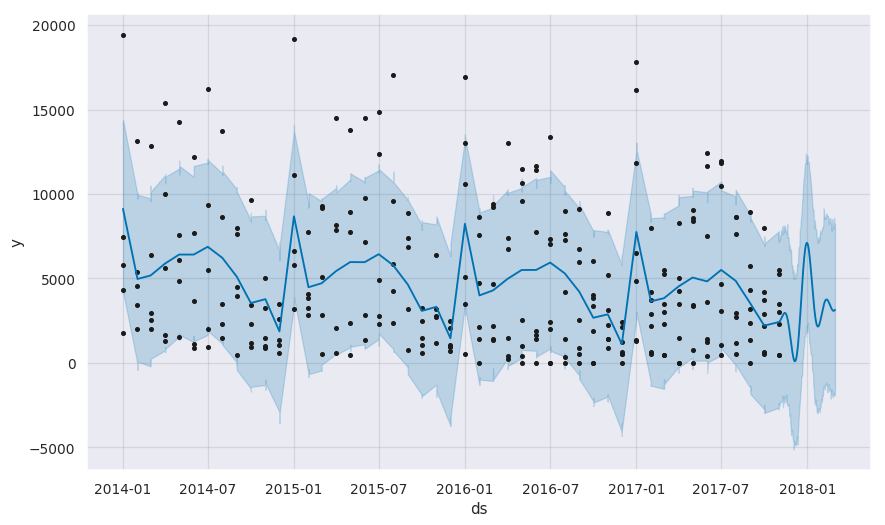

In [71]:
# visualizing predicions
my_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:

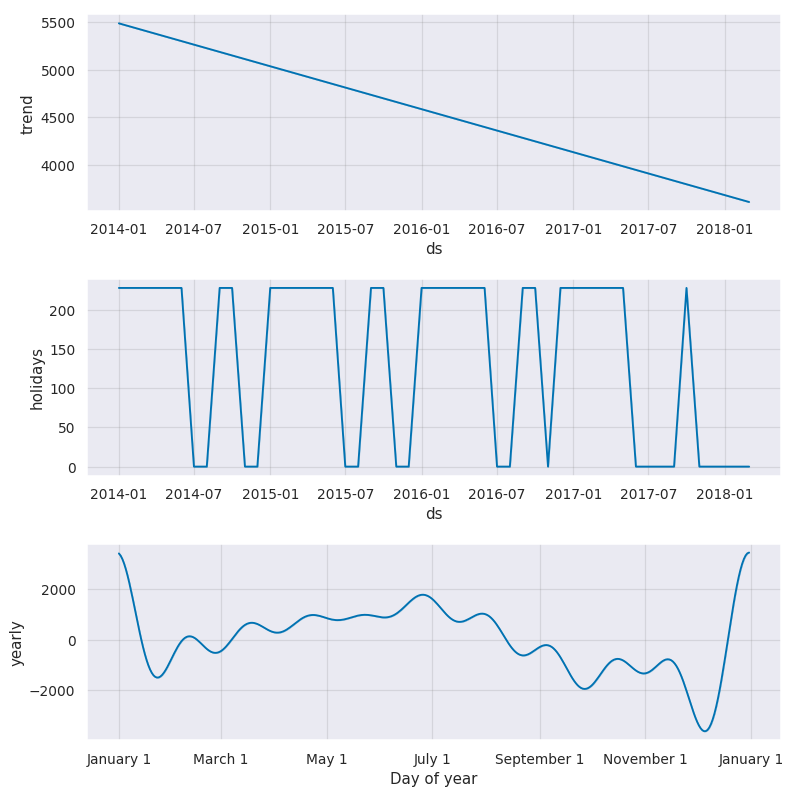

In [72]:
my_model.plot_components(forecast);


The first plot shows that the monthly sales of store number 1 has been linearly decreasing  over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the yearly volume of trend.

### Performance Matrics

In [73]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
m = Prophet(holidays=holidays, weekly_seasonality=True).fit(sales)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()


# train = performance_metrics(train)
# train.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2016-05-05 00:00:00 and 2016-11-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-01,6972.222169,1951.880378,12379.924004,1633.9758,2016-05-05
1,2016-06-01,6972.222169,1772.781980,12689.438274,1441.7861,2016-05-05
2,2016-06-01,6972.222169,2012.027289,12599.387614,11401.1170,2016-05-05
3,2016-06-01,6972.222169,1224.526292,12351.254446,11642.1730,2016-05-05
4,2016-06-01,6972.222169,1918.631676,12247.924551,1903.7552,2016-05-05


In [74]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
11,57 days,1.134245e+07,3367.856063,2460.346591,inf,0.7500
10,57 days,1.078498e+07,3284.048928,2403.244792,inf,0.8125
9,57 days,1.146797e+07,3386.438755,2460.286417,inf,0.8125
8,57 days,1.325848e+07,3641.219206,2617.679048,inf,0.7500
7,57 days,1.449005e+07,3806.579505,2728.501001,inf,0.6875


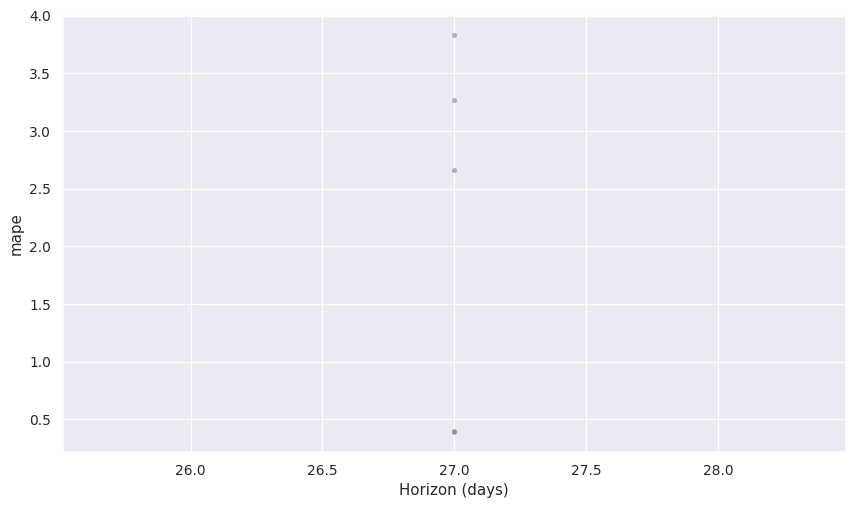

In [75]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


### Conclusion of Time Series forecasting

During this part we discussed time series analysis with `.seasonal_decompose()`, `ACF` and `PCF` plots and fited forecasting model using a new procedure by Facebook `Prophet`.

We can now present main advantages and drawbacks of time series forecasting:

__Advantages__
- Powerfull tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manualy).
- Easily implemented with `auto.arima()` from `forecast` package, which runs a complex grid search and sophisticated algorythm behind the scene.

__Drawbacks__
- Doesn't catch interactions between external features, which could improve the forecasting power of a model. Even in our case, we don't have this question, but these variables like `Special` and `CompetitionOpen` or `Special Holiday`. 
- Eventhough Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the the biggest drawback for new companies.
- Seasonal ARIMA in Python has 7 hyperparameters which can be tuned only manually affecting significantly the speed of the forecasting process.

## Alternative Approach: Regression XGBoost

[XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/model.md) is an implementation of Gradient Boosted Decision trees designed for speed and performance. Its more suitable name is a as [regularized Gradient Boosting](http://datascience.la/xgboost-workshop-and-meetup-talk-with-tianqi-chen/), as it uses a more regularized model formalization to control over-fitting. 

Additional advantages of this algorythm are:

- Automated missing values handling: XGB uses a "learned" default direction for the missing values. "Learned" means learned in the tree construction process by choosing the best direction that optimizes the training loss.
- Interactive feature analysis (yet implemented only in R): plots the structure of decision trees with splits and leaves.
- Feature importance analysis: a sorted barplot of the most significant variables.

<div class = "alert alert-block alert-info"> As we already saw in the previos section our data is higly seasonal and not random (dependent). Therefore, before fitting any models we need to "smooth" target variable Sales. The typical preprocessing step is to log transform the data in question. Once we perform the forecasting we will unwind log transformations in reverse order. </div>

### Quick Run through

In [39]:
from sklearn.model_selection import train_test_split
# to predict to
dataset = pd.read_csv("/home/CORPUSERS/28850775/Documents/data-sci/data/ResultDataMonth_train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'YearMonth')

train,test = train_test_split(dataset,test_size=0.2)

# msk = np.random.rand(len(train)) < 0.8
# train = train[msk]
# test = train[~msk]
print(train.shape)
print(test.shape)

test.head()

(1264, 11)
(316, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2016-02-01,East,9310070030,33,pack1,8667.1445,5765.80470,2016,2,1,7,1
2017-11-01,North,1698579415,53,pack1,591.5498,196.74687,2017,11,4,0,0
2015-08-01,North,2992101565,34,pack3,1076.8790,7739.60550,2015,8,3,0,0
2015-02-01,Inner,1698579415,53,pack1,2664.6135,812.42761,2015,2,1,7,1
2015-04-01,South,6179328252,34,pack1,5144.1357,3183.39090,2015,4,2,3,1


Even ETL process has been done, we don't need it anymore, just simply follow the process. 

In [40]:
# test: missing values? just a double check
test.isnull().sum()

Region        0
ItemCode      0
BrandCode     0
Package       0
ShipQty       0
SalesQty      0
Year          0
Month         0
Quarter       0
HolidayDay    0
IsHoliday     0
dtype: int64

In [41]:
test[pd.isnull(test.ShipQty ==0)]

,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,


### Data Encoding

XGBoost doesn't support anything else than numbers. So prior to modeling we need to encode certain factor variables into numerical plus extract dates as we did before for the train set.

In [42]:
# data extraction
# test['Year'] = test.index.year
# test['Month'] = test.index.month
# test['Day'] = test.index.day
# test['WeekOfYear'] = test.index.weekofyear
# to numerical
mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}

# test.StateHoliday.replace(mappings, inplace = True)
train.Region.replace(mappings, inplace = True) 
train.Package.replace(mappings_pkg, inplace = True)
test.Region.replace(mappings, inplace = True)
test.Package.replace(mappings_pkg, inplace = True)
print(train)
# train_store.Assortment.replace(mappings, inplace = True)
# train_store.StoreType.replace(mappings, inplace = True)
# train_store.StateHoliday.replace(mappings, inplace = True)
# train_store.drop('PromoInterval', axis = 1, inplace = True)
# store.StoreType.replace(mappings, inplace = True)
# store.Assortment.replace(mappings, inplace = True)
# store.drop('PromoInterval', axis = 1, inplace = True)

            Region    ItemCode  BrandCode  Package      ShipQty  \
YearMonth                                                         
2015-02-01       2  2111256114         33        1  10622.73700   
2016-11-01       3  5676563080         33        2    444.09485   
2016-11-01       3  5763825994         33        0   6956.96340   
2015-03-01       4  6179328252         34        0   3681.01860   
2015-10-01       1  3747832079         34        1   2222.80180   
2014-03-01       2  6179328252         34        0  13421.75200   
2015-12-01       4  6179328252         34        0   2197.47490   
2014-09-01       3  2111256114         33        1  10951.11000   
2017-06-01       1  6179328252         34        0   1557.76220   
2015-03-01       2  2111256114         33        1  11869.95400   
2014-10-01       3  5763825994         33        0   6860.57860   
2014-10-01       4  3747832079         34        1   3925.78000   
2017-10-01       3  3747832079         34        1   4304.0166

Returning back to the `train` data:

### Model Training

#### Approach

1. Split train data to train and test set to evaluate the model.
2. Set `eta` to a relatively high value (e.g. 0.05 ~ 0.1), num_round to 300 ~ 500
3. Use grid search to find the best combination of additional parameters.
4. Lower `eta` until we reach the optimum.
5. Use the validation set as watchlist to retrain the model with the best parameters. 

In [43]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train.columns if x not in [ 'ShipQty',]]
y = np.log(train.SalesQty) # log transformation of Sales
X = train
# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)
y_train.replace(-np.inf,1, inplace=True)
y_train.fillna(0,inplace=True)

# y_train[~train([np.nan,np.inf,-np.inf]).any(1)]
print(y_train)

YearMonth
2016-11-01     6.206364
2014-12-01     9.063062
2016-09-01    10.362627
2016-12-01     8.175473
2016-04-01     7.036441
2015-09-01     9.092324
2017-04-01     8.242155
2016-05-01     6.025055
2015-04-01     8.856160
2016-03-01     8.506755
2017-02-01     6.740032
2016-08-01     5.344706
2017-05-01     4.018321
2017-02-01     6.971540
2017-10-01     7.370705
2014-06-01     6.279673
2016-10-01     1.000000
2015-01-01    11.429029
2014-07-01     8.898993
2016-05-01     1.000000
2017-01-01     6.415520
2016-09-01     8.155795
2015-12-01     7.092005
2015-10-01     4.327498
2014-01-01     6.842143
2017-03-01     8.906695
2014-09-01    10.962837
2015-12-01     9.801837
2017-04-01    11.817611
2017-03-01    10.791308
                ...    
2017-11-01     1.000000
2014-04-01     8.892307
2017-04-01     4.435213
2014-03-01     8.405434
2016-08-01     8.731905
2017-05-01     7.797455
2016-02-01    11.514611
2014-08-01     9.598273
2016-07-01     8.354762
2015-05-01    11.444162
2016-1

In [44]:
# predictors
X[predictors].columns

Index(['Region', 'ItemCode', 'BrandCode', 'Package', 'SalesQty', 'Year',
       'Month', 'Quarter', 'HolidayDay', 'IsHoliday'],
      dtype='object')

In [45]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

# def rmspe(y, yhat):
#     return np.sqrt(np.mean((yhat / y-1) ** 2))

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE(y, yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmse(y, yhat):
    return np.sqrt(np.mean((y-yhat / y) ** 2))

def mse(y,yhat):
    return (1-np.sum((yhat-y)/y))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", metric_RMSPE(y, yhat)

def metric_RMSPE(y, yhat):

    y1 = np.array(yhat)
    y2 = np.array(y)
    n = len(y)
    temp = np.square((y1 - y2)/y2).sum()
    score = np.sqrt(temp/n)
    return score



#### Tuning Parameters

-  `eta`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [46]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [48]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.10646	test-rmse:inf	train-rmspe:0.979668	test-rmspe:1.03949
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.40388	test-rmse:inf	train-rmspe:0.976669	test-rmspe:1.04342
[2]	train-rmse:5.77084	test-rmse:inf	train-rmspe:0.973078	test-rmspe:1.04642
[3]	train-rmse:5.19956	test-rmse:inf	train-rmspe:0.968596	test-rmspe:1.04828
[4]	train-rmse:4.68577	test-rmse:inf	train-rmspe:0.962864	test-rmspe:1.04856
[5]	train-rmse:4.22224	test-rmse:inf	train-rmspe:0.955561	test-rmspe:1.04706
[6]	train-rmse:3.80467	test-rmse:inf	train-rmspe:0.94633	test-rmspe:1.04364
[7]	train-rmse:3.428	test-rmse:inf	train-rmspe:0.934796	test-rmspe:1.0378
[8]	train-rmse:3.08934	test-rmse:inf	train-rmspe:0.920695	test-rmspe:1.02939
[9]	train-rmse:2.78449	test-rmse:inf	train-rmspe:0.903816	test-rmspe:1.01826
[10]	train-rmse:2.51944	test-rmse:inf	train-rmspe:0.883613	test-rmspe:1.05171
[11]	train-

[102]	train-rmse:0.008233	test-rmse:inf	train-rmspe:0.008272	test-rmspe:0.630881
[103]	train-rmse:0.007962	test-rmse:inf	train-rmspe:0.008003	test-rmspe:0.630859
[104]	train-rmse:0.007913	test-rmse:inf	train-rmspe:0.007951	test-rmspe:0.630786
[105]	train-rmse:0.007755	test-rmse:inf	train-rmspe:0.007794	test-rmspe:0.630716
[106]	train-rmse:0.007548	test-rmse:inf	train-rmspe:0.00759	test-rmspe:0.630668
[107]	train-rmse:0.007412	test-rmse:inf	train-rmspe:0.007452	test-rmspe:0.630611
[108]	train-rmse:0.007258	test-rmse:inf	train-rmspe:0.007301	test-rmspe:0.6306
[109]	train-rmse:0.007154	test-rmse:inf	train-rmspe:0.007193	test-rmspe:0.630549
[110]	train-rmse:0.00698	test-rmse:inf	train-rmspe:0.007016	test-rmspe:0.630492
[111]	train-rmse:0.006786	test-rmse:inf	train-rmspe:0.006824	test-rmspe:0.630447
[112]	train-rmse:0.006681	test-rmse:inf	train-rmspe:0.006718	test-rmspe:0.630414
[113]	train-rmse:0.00656	test-rmse:inf	train-rmspe:0.006595	test-rmspe:0.63034
[114]	train-rmse:0.006475	test-rms

[204]	train-rmse:0.00121	test-rmse:inf	train-rmspe:0.001233	test-rmspe:0.629779
[205]	train-rmse:0.001187	test-rmse:inf	train-rmspe:0.00121	test-rmspe:0.629773
[206]	train-rmse:0.00117	test-rmse:inf	train-rmspe:0.001193	test-rmspe:0.629775
[207]	train-rmse:0.001169	test-rmse:inf	train-rmspe:0.001192	test-rmspe:0.62978
[208]	train-rmse:0.001169	test-rmse:inf	train-rmspe:0.001192	test-rmspe:0.629778
[209]	train-rmse:0.001155	test-rmse:inf	train-rmspe:0.001178	test-rmspe:0.629768
[210]	train-rmse:0.001143	test-rmse:inf	train-rmspe:0.001166	test-rmspe:0.629768
[211]	train-rmse:0.001134	test-rmse:inf	train-rmspe:0.001158	test-rmspe:0.629768
[212]	train-rmse:0.001124	test-rmse:inf	train-rmspe:0.001147	test-rmspe:0.629768
[213]	train-rmse:0.001108	test-rmse:inf	train-rmspe:0.001132	test-rmspe:0.62976
[214]	train-rmse:0.001103	test-rmse:inf	train-rmspe:0.001127	test-rmspe:0.629751
[215]	train-rmse:0.001103	test-rmse:inf	train-rmspe:0.001127	test-rmspe:0.62975
[216]	train-rmse:0.001093	test-rms

Last rows:

`
[44]	train-rmse:nan	test-rmse:nan	train-rmspe:27263.2	test-rmspe:40880.2
[45]	train-rmse:nan	test-rmse:nan	train-rmspe:27263.2	test-rmspe:40880.2
[46]	train-rmse:nan	test-rmse:nan	train-rmspe:27263.2	test-rmspe:40880.2
[47]	train-rmse:nan	test-rmse:nan	train-rmspe:27263.2	test-rmspe:40880.2
[48]	train-rmse:nan	test-rmse:nan	train-rmspe:27263.2	test-rmspe:40880.2
[49]	train-rmse:nan	test-rmse:nan	train-rmspe:27263.2	test-rmspe:40880.2
[50]	train-rmse:nan	test-rmse:nan	train-rmspe:27263.2	test-rmspe:40880.2
Stopping. Best iteration:
[0]	train-rmse:nan	test-rmse:nan	train-rmspe:27263.2	test-rmspe:40880.2
`

Essentially, we want the least value. The model with base hyperparameters gives out better result on the train set, indicating to the overfitting issue. 

### Grid Search from sklearn

Scikit learn wrapper is famous for the `GridSearchCV` and `RandomizedSearchCV`. Between these two, most of the time the [preference leans towards `RandomnizedSearchCV`](https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search), faster version of `GridSearchCV`. 

As an input, `RandomnizedSearchCV` takes only sklearn wrapper of XGboost, so instead of using the first version of a model, we build the analogous model in sklearn with `XGBRegressor`.

In [49]:
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

For parameters we will specify the regularization parameter `reg_alpha` which reduce model complexity and enhance performance, as well as `gamma` parameter which represents the minimum loss reduction required to make a split and also `max_depth` used to control over-fitting.

In [50]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)
# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

{'gamma': 1.6470058990703373, 'learning_rate': 0.19168938351997664, 'max_depth': 12, 'reg_alpha': 2.2866191783437637}
0.9903365188711343


In [51]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.08106924075327354, 
    'max_depth': 16, 
    'gamma': 2.0946975593149473,
    'reg_alpha': 2.1037132201029216,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 200, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.25509	test-rmse:inf	train-rmspe:0.980328	test-rmspe:1.03816
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 200 rounds.
[1]	train-rmse:6.67374	test-rmse:inf	train-rmspe:0.978021	test-rmspe:1.04151
[2]	train-rmse:6.1385	test-rmse:inf	train-rmspe:0.975404	test-rmspe:1.04361
[3]	train-rmse:5.64732	test-rmse:inf	train-rmspe:0.972381	test-rmspe:1.04509
[4]	train-rmse:5.19667	test-rmse:inf	train-rmspe:0.968618	test-rmspe:1.04626
[5]	train-rmse:4.78227	test-rmse:inf	train-rmspe:0.963897	test-rmspe:1.04751
[6]	train-rmse:4.40015	test-rmse:inf	train-rmspe:0.958415	test-rmspe:1.04605
[7]	train-rmse:4.04784	test-rmse:inf	train-rmspe:0.951654	test-rmspe:1.04318
[8]	train-rmse:3.72483	test-rmse:inf	train-rmspe:0.943528	test-rmspe:1.03879
[9]	train-rmse:3.42805	test-rmse:inf	train-rmspe:0.933547	test-rmspe:1.03465
[10]	train-rmse:3.16837	test-rmse:inf	train-rmspe:0.919957	test-rmspe:1.06963
[11]	tr

[102]	train-rmse:0.119944	test-rmse:inf	train-rmspe:0.14669	test-rmspe:0.740997
[103]	train-rmse:0.119939	test-rmse:inf	train-rmspe:0.14673	test-rmspe:0.741089
[104]	train-rmse:0.119931	test-rmse:inf	train-rmspe:0.146796	test-rmspe:0.741243
[105]	train-rmse:0.119931	test-rmse:inf	train-rmspe:0.146796	test-rmspe:0.741243
[106]	train-rmse:0.11992	test-rmse:inf	train-rmspe:0.146896	test-rmspe:0.741472
[107]	train-rmse:0.11992	test-rmse:inf	train-rmspe:0.146896	test-rmspe:0.741472
[108]	train-rmse:0.119912	test-rmse:inf	train-rmspe:0.146973	test-rmspe:0.741649
[109]	train-rmse:0.119912	test-rmse:inf	train-rmspe:0.146973	test-rmspe:0.741649
[110]	train-rmse:0.119912	test-rmse:inf	train-rmspe:0.146973	test-rmspe:0.741649
[111]	train-rmse:0.119912	test-rmse:inf	train-rmspe:0.146973	test-rmspe:0.741649
[112]	train-rmse:0.119906	test-rmse:inf	train-rmspe:0.147039	test-rmspe:0.7418
[113]	train-rmse:0.1199	test-rmse:inf	train-rmspe:0.147108	test-rmspe:0.741955
[114]	train-rmse:0.1199	test-rmse:in

[204]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147933	test-rmspe:0.743777
[205]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[206]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[207]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[208]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[209]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[210]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[211]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[212]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[213]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[214]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[215]	train-rmse:0.119857	test-rmse:inf	train-rmspe:0.147948	test-rmspe:0.743807
[216]	train-rmse:0.119857	te

Last five rows:
    
`
[194]	train-rmse:0.785001	test-rmse:inf	train-rmspe:inf	test-rmspe:321.57
[195]	train-rmse:0.785001	test-rmse:inf	train-rmspe:inf	test-rmspe:321.57
[196]	train-rmse:0.785001	test-rmse:inf	train-rmspe:inf	test-rmspe:321.227
[197]	train-rmse:0.785001	test-rmse:inf	train-rmspe:inf	test-rmspe:321.233
[198]	train-rmse:0.784922	test-rmse:inf	train-rmspe:inf	test-rmspe:321.238
[199]	train-rmse:0.783896	test-rmse:inf	train-rmspe:inf	test-rmspe:322.145
[200]	train-rmse:0.783602	test-rmse:inf	train-rmspe:inf	test-rmspe:323.357
Stopping. Best iteration:
[0]	train-rmse:7.48443	test-rmse:inf	train-rmspe:inf	test-rmspe:1.08594
`

We resolved an issue with overfitting, but due to the decrease of learning rate (`eta`) we got a bit worse overall score on the test set (~0.11 to ~0.14).

In [102]:
yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))


error = RMSPE(X_test.SalesQty.values, np.exp(yhat))
print('First validation yelds RMSPE: {:.6f}'.format(error))


First validation yelds RMSPE: 1.439206


Even though we observed a bit higher RMSPE value, we need to remember that the corresponding `eta` for the first version was 0.1, which is usually considered as high. I think that it's remarkable that we got more or less the same result but with 2x lower `eta` (0.1 to 0.04).

__Next steps towards model's improvement will involve further decrease of `eta`, tuning of correpsonding `gamma` and `max_depth`.__

### Model understanding

Feature importance scores help us see which variables contributed the most to the score.

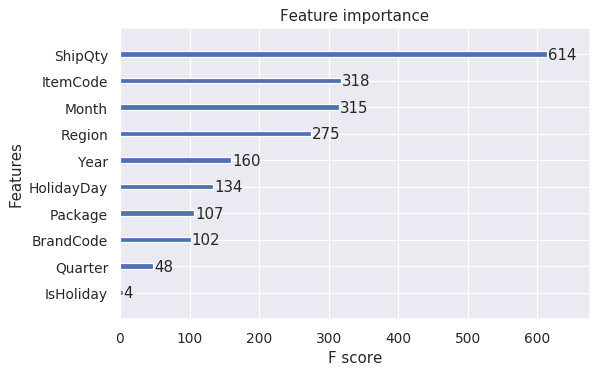

In [103]:
xgb.plot_importance(model_final)

Variables `ItemCode` and `Month` are both leading. Then go features `Region`,  `Year`, `HolidayDay`, `Package` ,`BrandCode`,`Quarter`,and deducted features `IsHoliday`.

### Prediction to unseen data

In [104]:
from sklearn.model_selection import train_test_split
# to predict to
# dataset = pd.read_csv("/home/CORPUSERS/28850775/Documents/data-sci/data/ResultDataMonth_train.csv", 
#                     parse_dates = True, low_memory = False, index_col = 'YearMonth')

dataset = train
train,test = train_test_split(dataset,test_size=0.2)
# predictions to unseen data

# mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
# mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}
# test.Region.replace(mappings, inplace = True)
# test.Package.replace(mappings_pkg, inplace = True)
unseen = xgb.DMatrix(test[predictors])
test_p = model_final.predict(unseen)
forecasts = pd.DataFrame({'ShipQty': test['ShipQty'], 
                          'SalesQty': np.exp(test_p)})
# forecasts
forecasts.head(12)

,ShipQty,SalesQty
YearMonth,,
2016-04-01,8584.12790,7316.903809
2015-03-01,9166.78520,49698.558594
2016-01-01,632.78003,6.367561
2017-04-01,3235.48140,9061.972656
2014-11-01,5470.58890,2102.810547
2014-04-01,18160.98000,32853.847656
2016-02-01,0.00000,12.428493
2017-04-01,3721.66260,1740.189087
2015-06-01,5198.30660,1644.641479


## Alternative another approach of LSTM 

In [106]:
import os 
import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout, Flatten, TimeDistributed,RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from pandas import HDFStore
import numpy as np 



ModuleNotFoundError: No module named 'keras'

## Feature Engineering

In [45]:
# dataset = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
#                     parse_dates = True, low_memory = False, index_col = 'YearMonth')

# train,test = train_test_split(dataset,test_size=0.2)

# mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
# mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}

# # test.StateHoliday.replace(mappings, inplace = True)
# train.Region.replace(mappings, inplace = True) 
# train.Package.replace(mappings_pkg, inplace = True)
# test.Region.replace(mappings, inplace = True)
# test.Package.replace(mappings_pkg, inplace = True)
# print(train)
def normarlize():
    train_norm = train.apply(lambda x: (x-np.mean(x)/(np.max(x) - np.min(x))))
    return train_norm 


def shuffle(X,Y):
    np.random.seed(20)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(units = 1,  activation = 'relu', input_shape =(1,11)))
#     model.add(Flatten())
    model.add(Dense(1))
    model.add(Dropout(0.5))
    model.compile(loss="mse",optimizer="adam")
    
    model.summary()
    return model


### splite data & training 

In [52]:
predictors = [x for x in train.columns if x not in [ 'SalesQty']]
y = np.log(train.SalesQty) # log transformation of Sales
X = train[predictors]

# print(X)
# print('===========================')
# print(y_train)
# print('==============================')
# print(y_train.shape)
# # split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)
print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)
y_train.replace(-np.inf,1, inplace=True)
y_train.fillna(0,inplace=True)
# callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# X_train = X_train.



model = buildManyToOneModel(X_train.shape)
# print(X_train.shape)
# print(X_train.values)
X_train=X_train.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
# X_train = X_train.values.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
# X_train = np.reshape(X_train,(-1,1, X_train.shape[1]))
# X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
model.fit(X_train, y_train, epochs=100, batch_size= 884, verbose=1)


(884, 10) (884,) (380, 10) (380,)


NameError: name 'Sequential' is not defined

---

## Final thoughts

Time Series Analysis is a must for time series data. It goes much deeper than ad-hoc Exploratory Data Analysis, revealing trends, non randomness of the data and seasonalities.

I was particularly excited to use a new forecasting procedure Prophet. Eventhough this tool is still under development, it has everything set for the advanced modeling as it can account for change points in trends and holidays in the data. In the meantime, the most sophisticated tool for the Time Series Analysis stays auto.arima from R forecast package.

A significant jump in the forecasting performance of the model fitted above, XGboost with xgboost library, can be achieved by increasing the number and range of hyperparameters. Due to the number of observations (800k) and with a laptop like mine, the "more developped" grid search would take about 2-3 days to fit. So I left this room for the improvement for later notebooks.

Another method that I didn't cover here is a regression model Stacking, which works great for small or medium size data sets. We would basically combine XGboost, RandomForest, NN and SVM for regression. And then stack them together by building the final model.